# Clasificación de Fugas con Escalogramas CWT

## 1. Instalación de Dependencias e Importación de Librerías

In [1]:
# Instalación de dependencias para wavelet denoising
!pip install PyWavelets

# Instalación de dependencias para fCWT
!git clone https://github.com/fastlib/fCWT.git
!pip install fCWT
!apt-get update
!apt-get install libfftw3-single3 -y

# Importación de bibliotecas necesarias
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import seaborn as sns
import h5py
from tqdm import tqdm
import random
import pywt
import fCWT
from fcwt.boilerplate import cwt, plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Importar la clase WaveletDenoising
from denoising import WaveletDenoising

# Montar Google Drive (para Colab)
from google.colab import drive
drive.mount('/content/drive')

# Configuraciones globales para visualización
plt.style.use('seaborn-v0_8-whitegrid')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 51.7 MB/s eta 0:00:00
Cloning into 'fCWT'...
remote: Enumerating objects: 705, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 705 (delta 84), reused 70 (delta 68), pack-reused 606 (from 2)
Receiving objects: 100% (705/705), 19.49 MiB | 6.05 MiB/s, done.
Resolving deltas: 100% (426/426), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 30.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fCWT: filename=fcwt-0.1.18-cp311-cp311-linux_x86_64.whl size=4890004 sha256=e2f271442789646ad0c3fef61d746a31996c52cc3928bfec518d5a283c7a21fe
  Stored in directory: /root/.cache/pip/wheels/45/32/fc/c41c3b3da47873dd2e4e65712e62944d6814246c61e0364005
Successfully built fCWT
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86

## 2. Cargar y Visualizar Datos

Data Directory: /content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched
Sample Rate: 25600 Hz
Classification Mode: five_classes
Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


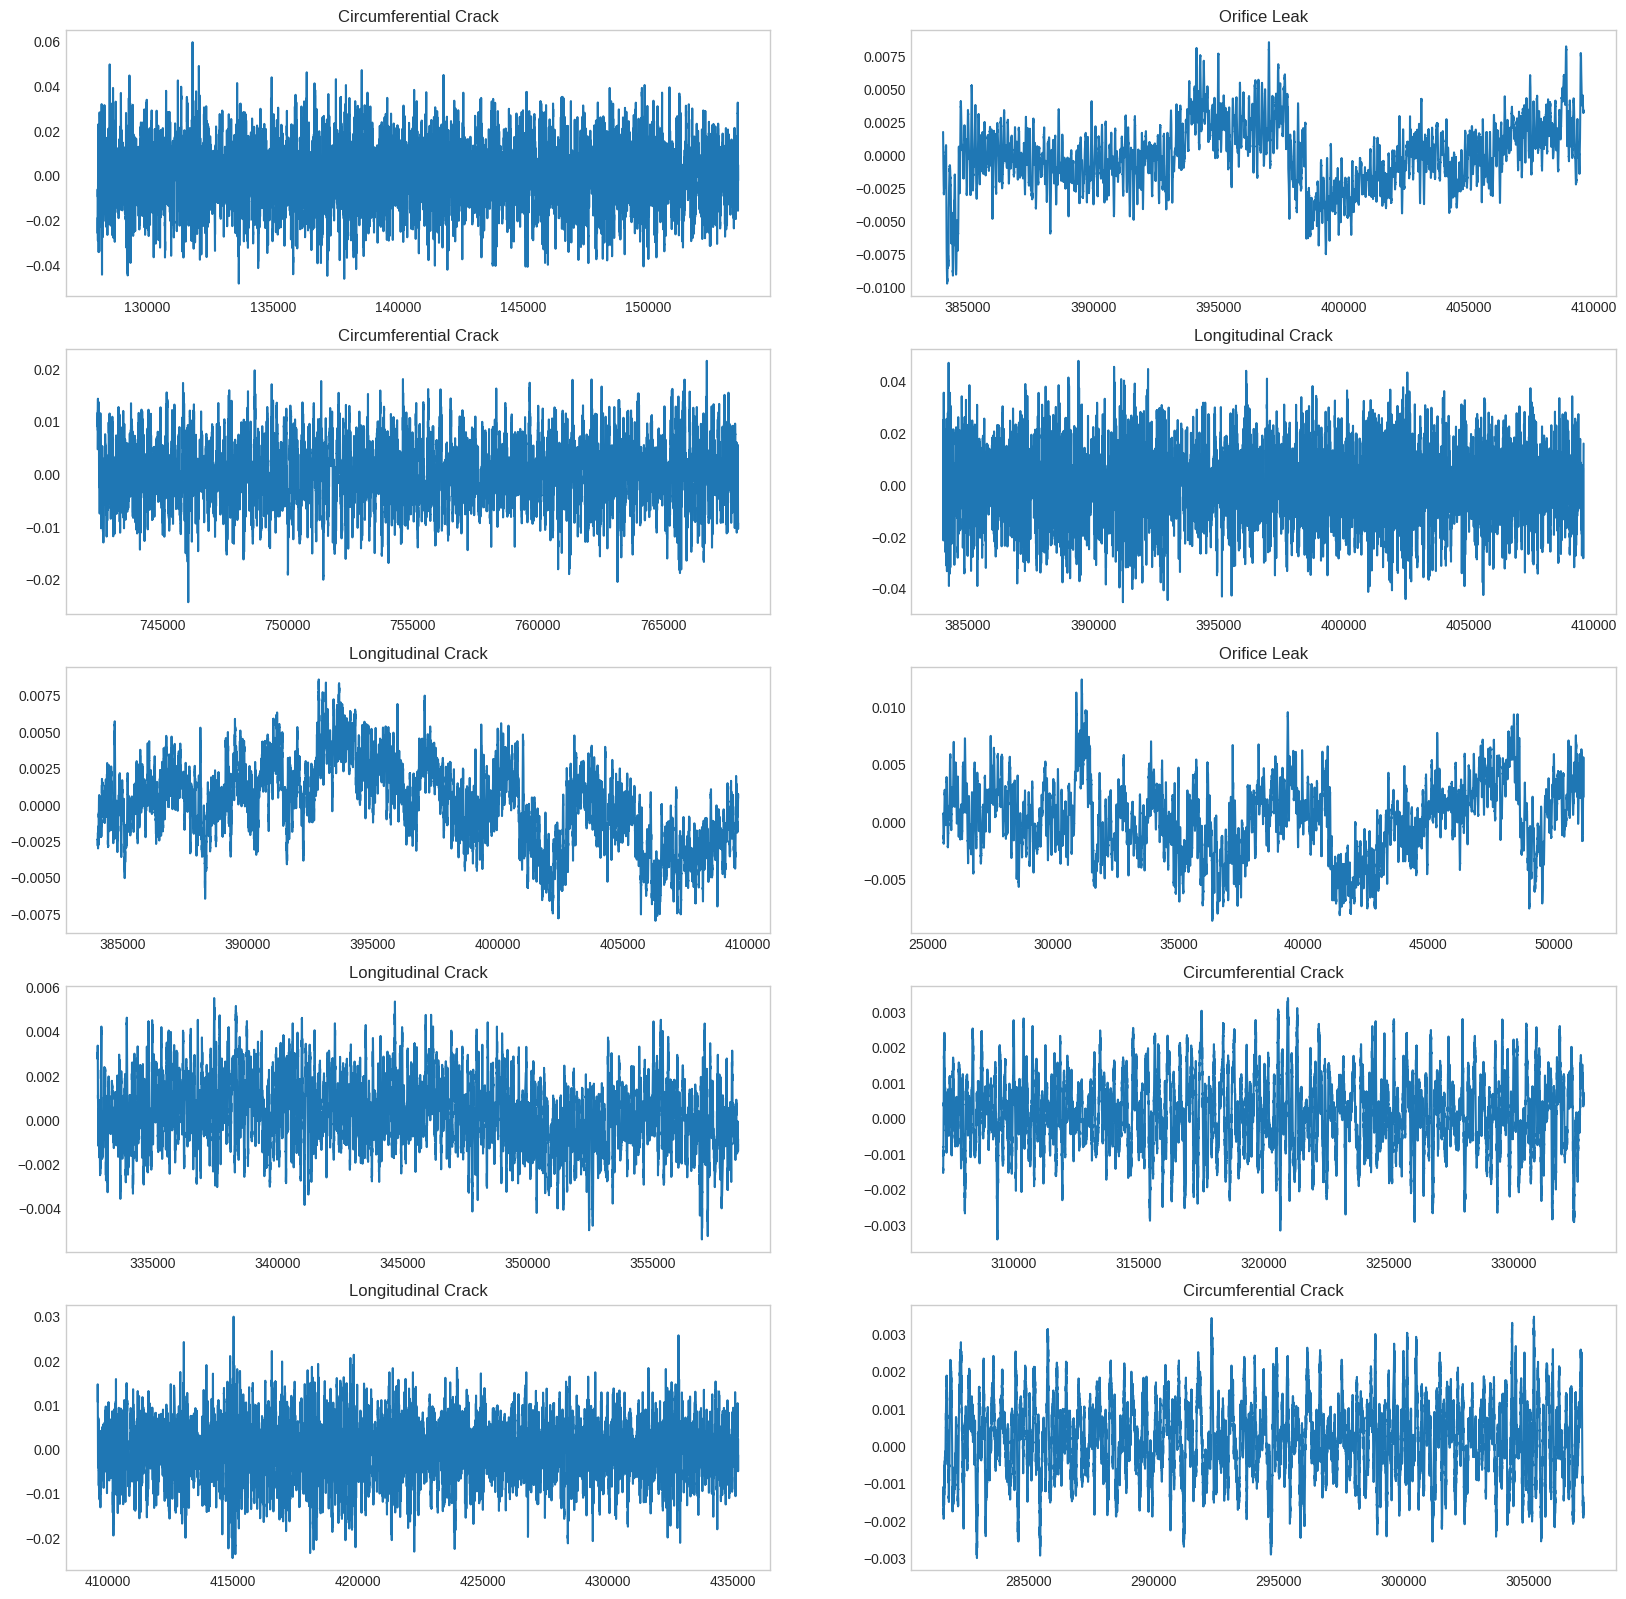

In [2]:
# Cambiando la ruta para acceder a los datos en Google Drive
data_dir = '/content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched'
original_sr = 25600  # in Hz
signal_sr = 25600  # in Hz
downsample_factor = original_sr//signal_sr

# Modo de clasificación: 'five_classes' o 'binary'
classification_mode = 'five_classes'  # Cambiar según necesidad

# Definir diccionarios de etiquetas según el modo de clasificación
if classification_mode == 'five_classes':
    label_codes_dict = {'Circumferential Crack': 0, 'Gasket Leak': 1, 'Longitudinal Crack': 2, 'No-leak': 3, 'Orifice Leak': 4}
else:  # binary
    label_codes_dict = {'Leak': 0, 'No-leak': 1}

# Esta función elimina el archivo .DS_Store si existe en la ruta definida
def remove_DS_store_file(path):
    # Buscar tanto .DS_Store como .DS_store (diferencias de capitalización)
    for ds_name in ['.DS_Store', '.DS_store']:
        ds_store_file_location = os.path.join(path, ds_name)
        if os.path.isfile(ds_store_file_location):
            os.remove(ds_store_file_location)

def load_accelerometer_data(data_dir, sample_rate, downsample_factor, label_codes, mode='five_classes', fraction_to_include=1):
    """
    Carga datos de acelerómetro con opción para clasificación binaria o multiclase

    Args:
        data_dir: Directorio donde se encuentran los datos
        sample_rate: Tasa de muestreo deseada
        downsample_factor: Factor de submuestreo
        label_codes: Diccionario de códigos de etiquetas
        mode: 'five_classes' o 'binary'
        fraction_to_include: Fracción de frames a incluir

    Returns:
        signals: Lista de señales
        labels: Lista de etiquetas
    """
    # Eliminar .DS_Store si existe en data_dir
    remove_DS_store_file(data_dir)

    signals = []
    labels = []

    # Para el modo binario, necesitamos contabilizar cuántos frames hay por cada tipo de fuga
    leak_counts = {
        'Circumferential Crack': 0,
        'Gasket Leak': 0,
        'Longitudinal Crack': 0,
        'Orifice Leak': 0
    }
    leak_signals = {
        'Circumferential Crack': [],
        'Gasket Leak': [],
        'Longitudinal Crack': [],
        'Orifice Leak': []
    }
    no_leak_signals = []
    no_leak_labels = []

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)

        # Verificar que sea un directorio antes de procesarlo
        if not os.path.isdir(label_dir):
            print(f"Omitiendo {label_dir} porque no es un directorio")
            continue

        # Eliminar .DS_Store si existe
        remove_DS_store_file(label_dir)

        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)

            # Verificar que sea un archivo
            if not os.path.isfile(file_path):
                continue

            # Cargar el archivo csv
            accelerometer_signal_df = pd.read_csv(file_path, index_col=False)

            # Submuestrear seleccionando cada n-ésima fila
            accelerometer_signal_df = accelerometer_signal_df.iloc[::downsample_factor, :]
            accelerometer_signal_df = accelerometer_signal_df.reset_index(drop=True)

            # Obtener 30 segundos de datos
            accelerometer_signal = accelerometer_signal_df['Value'][0:(sample_rate*30)]

            # Generar un vector con el índice de inicio para cada frame de 1 segundo
            sample_indexes = np.linspace(0,len(accelerometer_signal)-sample_rate,len(accelerometer_signal)//sample_rate)

            # Obtener el número de frames de señal
            signal_frames_number = fraction_to_include*len(sample_indexes)
            signal_frames_counter = 0

            # Generar frames de señal de 1 segundo a partir de la señal original
            for signal_frame in sample_indexes:
                accelerometer_signal_frame = accelerometer_signal[int(signal_frame):int(signal_frame+sample_rate)]
                signal_frames_counter+=1

                if signal_frames_counter > signal_frames_number:
                    break

                if len(accelerometer_signal_frame) != sample_rate:
                    continue

                if mode == 'five_classes':
                    # Guardar directamente para clasificación de 5 clases
                    signals.append(accelerometer_signal_frame)
                    labels.append(label_codes[label])
                else:  # modo binario
                    # Para modo binario, guardamos las señales según su tipo
                    if label == 'No-leak':
                        no_leak_signals.append(accelerometer_signal_frame)
                        no_leak_labels.append(1)  # 1 para No-leak en modo binario
                    else:
                        # Guardar en la categoría correspondiente
                        leak_signals[label].append(accelerometer_signal_frame)
                        leak_counts[label] += 1

    # Si estamos en modo binario, equilibramos el dataset
    if mode == 'binary':
        # Encontrar la cantidad mínima de ejemplos por tipo de fuga
        min_count_per_leak_type = min(leak_counts.values()) if leak_counts else 0

        # Calcular cuántos ejemplos necesitamos de cada tipo para equilibrar con No-leak
        if len(no_leak_signals) > 0 and len(leak_counts) > 0:
            total_leak_samples_needed = len(no_leak_signals)
            samples_per_leak_type = total_leak_samples_needed // len(leak_counts)

            # Asegurar que no tomamos más muestras de las disponibles
            samples_per_leak_type = min(samples_per_leak_type, min_count_per_leak_type)

            # Seleccionar muestras equilibradas de cada tipo de fuga
            balanced_leak_signals = []
            for leak_type in leak_signals:
                if leak_signals[leak_type]:
                    # Tomar una muestra aleatoria del tamaño necesario
                    selected_signals = random.sample(leak_signals[leak_type],
                                                    min(samples_per_leak_type, len(leak_signals[leak_type])))
                    balanced_leak_signals.extend(selected_signals)

            # Crear etiquetas para las señales de fuga (0 para Leak en modo binario)
            balanced_leak_labels = [0] * len(balanced_leak_signals)

            # Combinar todo
            signals = balanced_leak_signals + no_leak_signals
            labels = balanced_leak_labels + no_leak_labels

            print(f"Modo binario: {len(balanced_leak_labels)} muestras de fuga, {len(no_leak_labels)} muestras sin fuga")

    return signals, labels

# Cargar los datos desde Google Drive
signals_lst, labels_lst = load_accelerometer_data(
    data_dir,
    signal_sr,
    downsample_factor,
    label_codes_dict,
    mode=classification_mode,
    fraction_to_include=1
)

signals_dict = {'training': [], 'testing': []}
labels_dict = {'training': [], 'testing': []}

# Generar diccionarios con subconjuntos de entrenamiento y prueba a partir de los datos cargados
signals_dict['training'], signals_dict['testing'], labels_dict['training'], labels_dict['testing'] = train_test_split(
    signals_lst,
    labels_lst,
    test_size=0.2,
    random_state=53
)

# Imprimir información sobre el dataset resultante:
print(f'Data Directory: {data_dir}')
print(f'Sample Rate: {signal_sr} Hz')
print(f'Classification Mode: {classification_mode}')
print(f'Number of signals (training, testing): ({len(signals_dict["training"])}, {len(signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(signals_dict["training"][np.random.randint(0,len(signals_dict["training"]))])}')

# Graficar algunas de las señales resultantes
plt.figure(figsize=(20, 20))
rows = 5
cols = 2
n = rows * cols
random_index = []

for i in range(n):
    plt.subplot(rows, cols, i+1)
    random_index.append(np.random.randint(0, len(signals_dict['training'])))
    plt.plot(signals_dict['training'][random_index[i]])

    # Obtener el nombre de la etiqueta según el modo de clasificación
    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()

## 3. Normalización y Denoising con Wavelet

Denoising testing signals: 100%|██████████| 240/240 [00:00<00:00, 289.64it/s]


Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


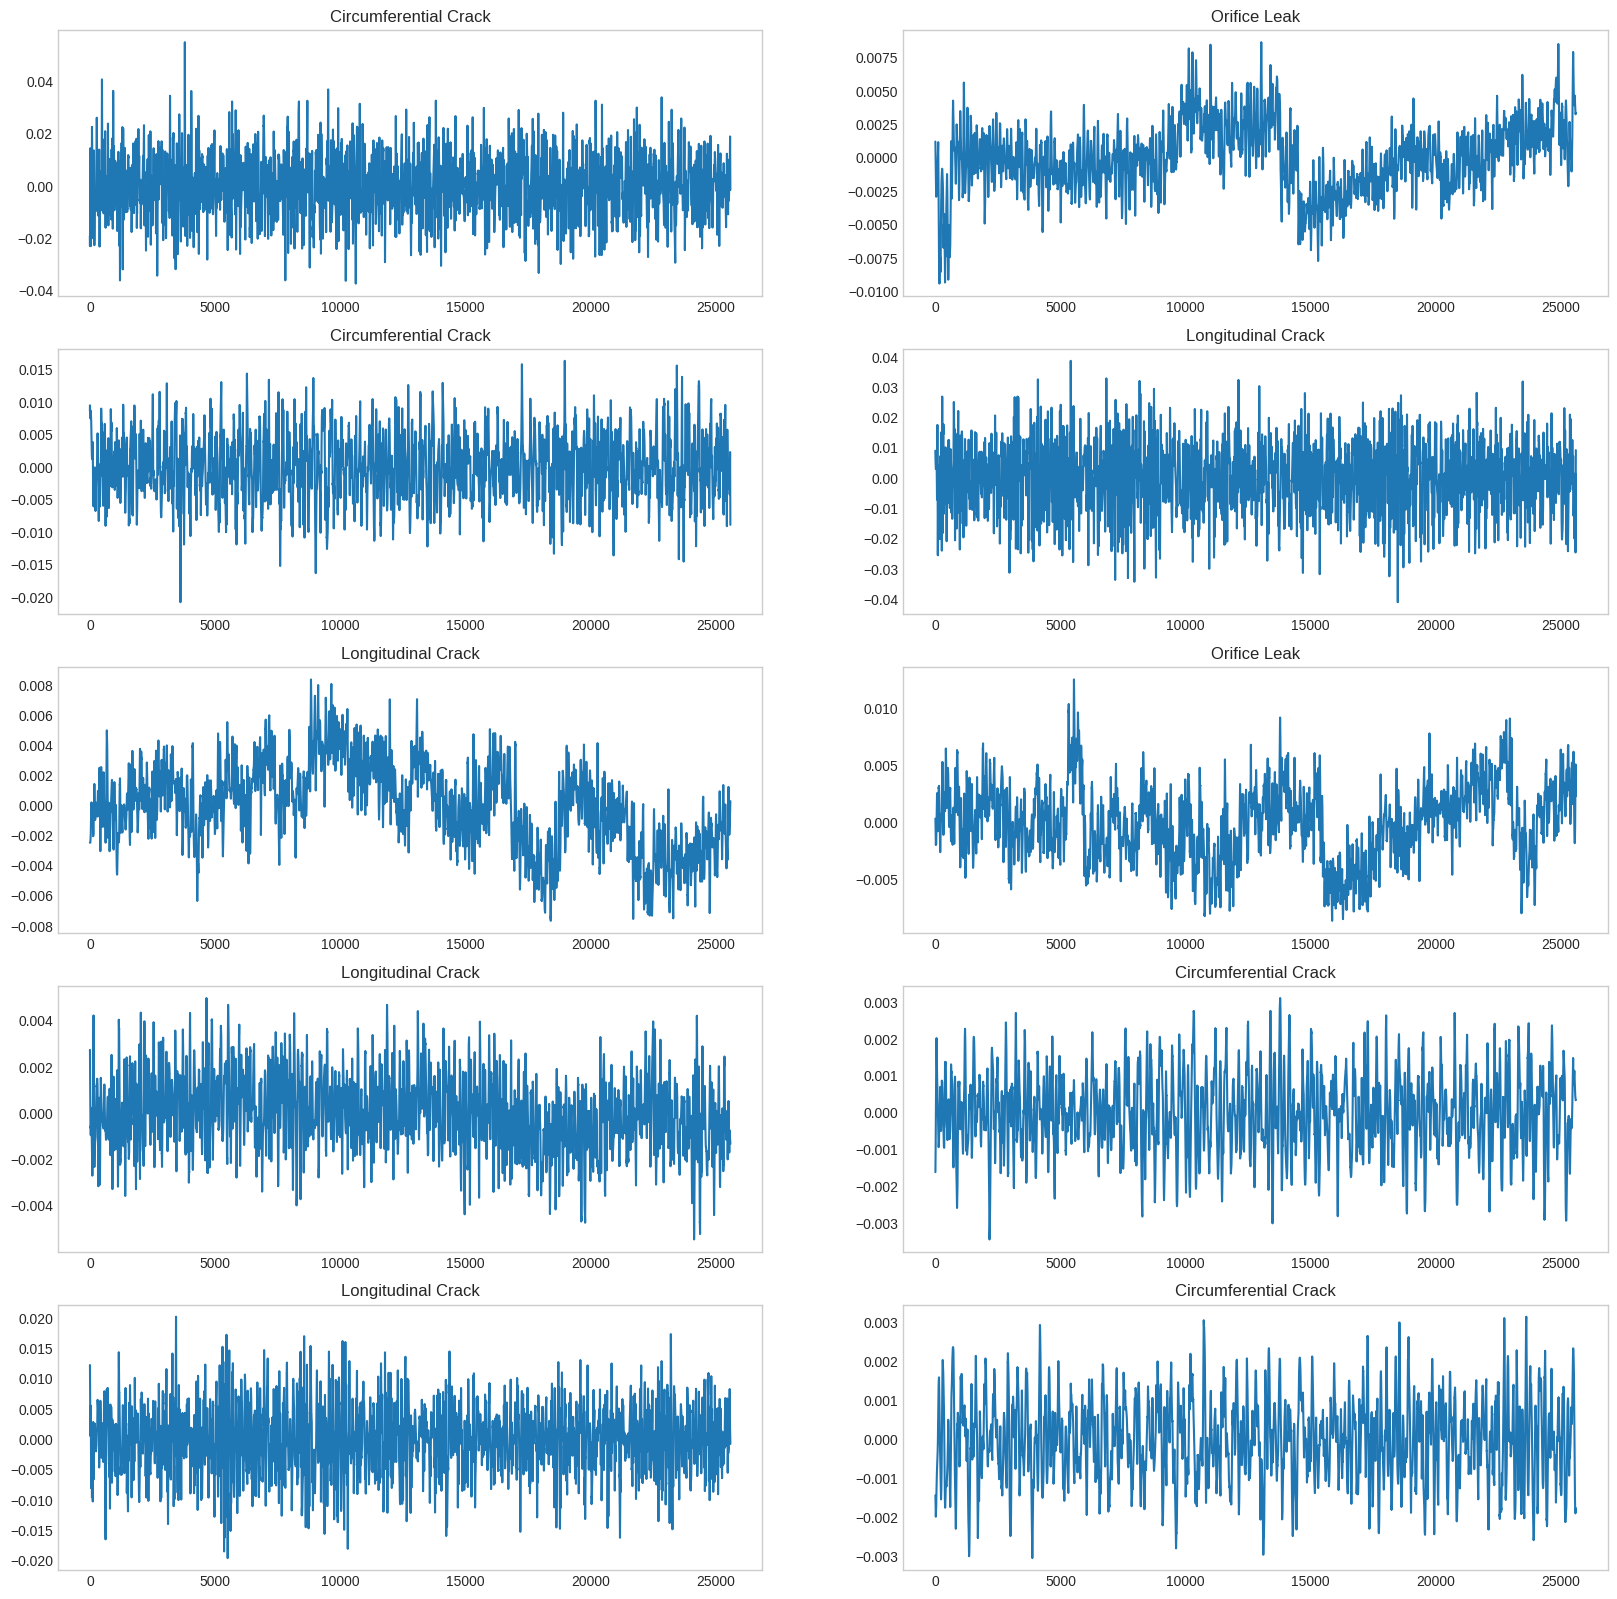

In [3]:
def wavelet_denoise(signals_dict, labels_dict):
    """
    Normaliza y aplica denoising wavelet a las señales

    Args:
        signals_dict: Diccionario con señales de entrenamiento y prueba
        labels_dict: Diccionario con etiquetas de entrenamiento y prueba

    Returns:
        wavelet_denoised_signals: Diccionario con señales procesadas
        labels_dict: Diccionario con etiquetas
    """
    # Crear un objeto de la clase WaveletDenoising
    wd = WaveletDenoising(normalize=True,
                      wavelet='sym3',
                      level=4,
                      thr_mode='soft',
                      method="universal")

    # Crear un nuevo diccionario para almacenar los coeficientes calculados:
    wavelet_denoised_signals = {'training': [], 'testing': []}

    for key, signals_subset in signals_dict.items():
        for signal_element in tqdm(signals_subset, desc=f"Denoising {key} signals"):
            # Denoising de la señal usando el método wavelet denoising
            denoised_signal = wd.fit(signal_element)

            # Almacenar las señales denoised en el nuevo diccionario
            wavelet_denoised_signals[key].append(denoised_signal)

    return wavelet_denoised_signals, labels_dict

# Denoising de las señales en los diccionarios de entrenamiento y prueba
wavelet_denoised_signals_dict, labels_dict = wavelet_denoise(signals_dict=signals_dict, labels_dict=labels_dict)

# Imprimir información sobre el dataset resultante:
print(f'Number of signals (training, testing): ({len(wavelet_denoised_signals_dict["training"])}, {len(wavelet_denoised_signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(wavelet_denoised_signals_dict["training"][0])}')

# Graficar algunas de las señales resultantes
plt.figure(figsize=(20, 20))
rows = 5
cols = 2
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.plot(wavelet_denoised_signals_dict['training'][random_index[i]])

    # Obtener el nombre de la etiqueta según el modo de clasificación
    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()

## 4. Cálculo de Escalogramas con CWT

In [4]:
def signal_extend_forecasting(signal, extend_length, M=None, K=None):
    """
    Extiende una señal utilizando el algoritmo de forecasting BoundEffRed.

    Args:
        signal: Señal a extender
        extend_length: Cantidad de puntos a extender
        M: Longitud de los subsegmentos (default: len(signal)//8)
        K: Número de subsegmentos (default: 2.5*M)

    Returns:
        Señal extendida
    """
    N = len(signal)

    # Configuración de parámetros
    if M is None:
        M = N // 8  # Aproximadamente 1/8 de la señal original
        M = max(M, 16)  # Al menos 16 puntos

    if K is None:
        K = int(2.5 * M)  # 2.5 veces M como sugiere el paper
        K = min(K, N - M)  # Pero no más que los puntos disponibles

    # Construir matrices X e Y
    X = np.zeros((M, K))
    Y = np.zeros((M, K))

    for k in range(K):
        X[:, k] = signal[N - K - M + k:N - K + k]
        Y[:, k] = signal[N - K + k - 1:N - K + k + M - 1]

    # Estimar la matriz dinámica A
    A = Y @ X.T @ np.linalg.pinv(X @ X.T)

    # Extender la señal hacia adelante
    extended_signal = np.copy(signal)
    last_segment = signal[-M:]

    for i in range(extend_length):
        # Predecir el siguiente punto
        next_point = A[-1, :] @ last_segment
        extended_signal = np.append(extended_signal, next_point)

        # Actualizar el último segmento
        last_segment = np.append(last_segment[1:], next_point)

    # Verificar la longitud y ajustar si es necesario
    expected_length = len(signal) + extend_length
    if len(extended_signal) != expected_length:
        if len(extended_signal) < expected_length:
            # Añadir elementos si faltan
            padding = expected_length - len(extended_signal)
            extended_signal = np.pad(extended_signal, (0, padding), mode='edge')
        else:
            # Recortar si hay demasiados
            extended_signal = extended_signal[:expected_length]

    return extended_signal

Método de manejo de bordes: z_scalogram
Calculando Z-Scalogram (coeficientes fuera del COI = 0)


Calculando CWT: 100%|██████████| 960/960 [00:38<00:00, 24.75it/s]


Escalogramas calculados: 48000
Forma de un escalograma: (512, 10)
Método de manejo de bordes: z_scalogram
Calculando Z-Scalogram (coeficientes fuera del COI = 0)


Calculando CWT: 100%|██████████| 240/240 [00:05<00:00, 47.31it/s]


Escalogramas calculados: 12000
Forma de un escalograma: (512, 10)
Número de escalogramas de entrenamiento: 48000
Número de escalogramas de prueba: 12000
Forma de un escalograma: (512, 10)

Escalogramas con método de reflexión:


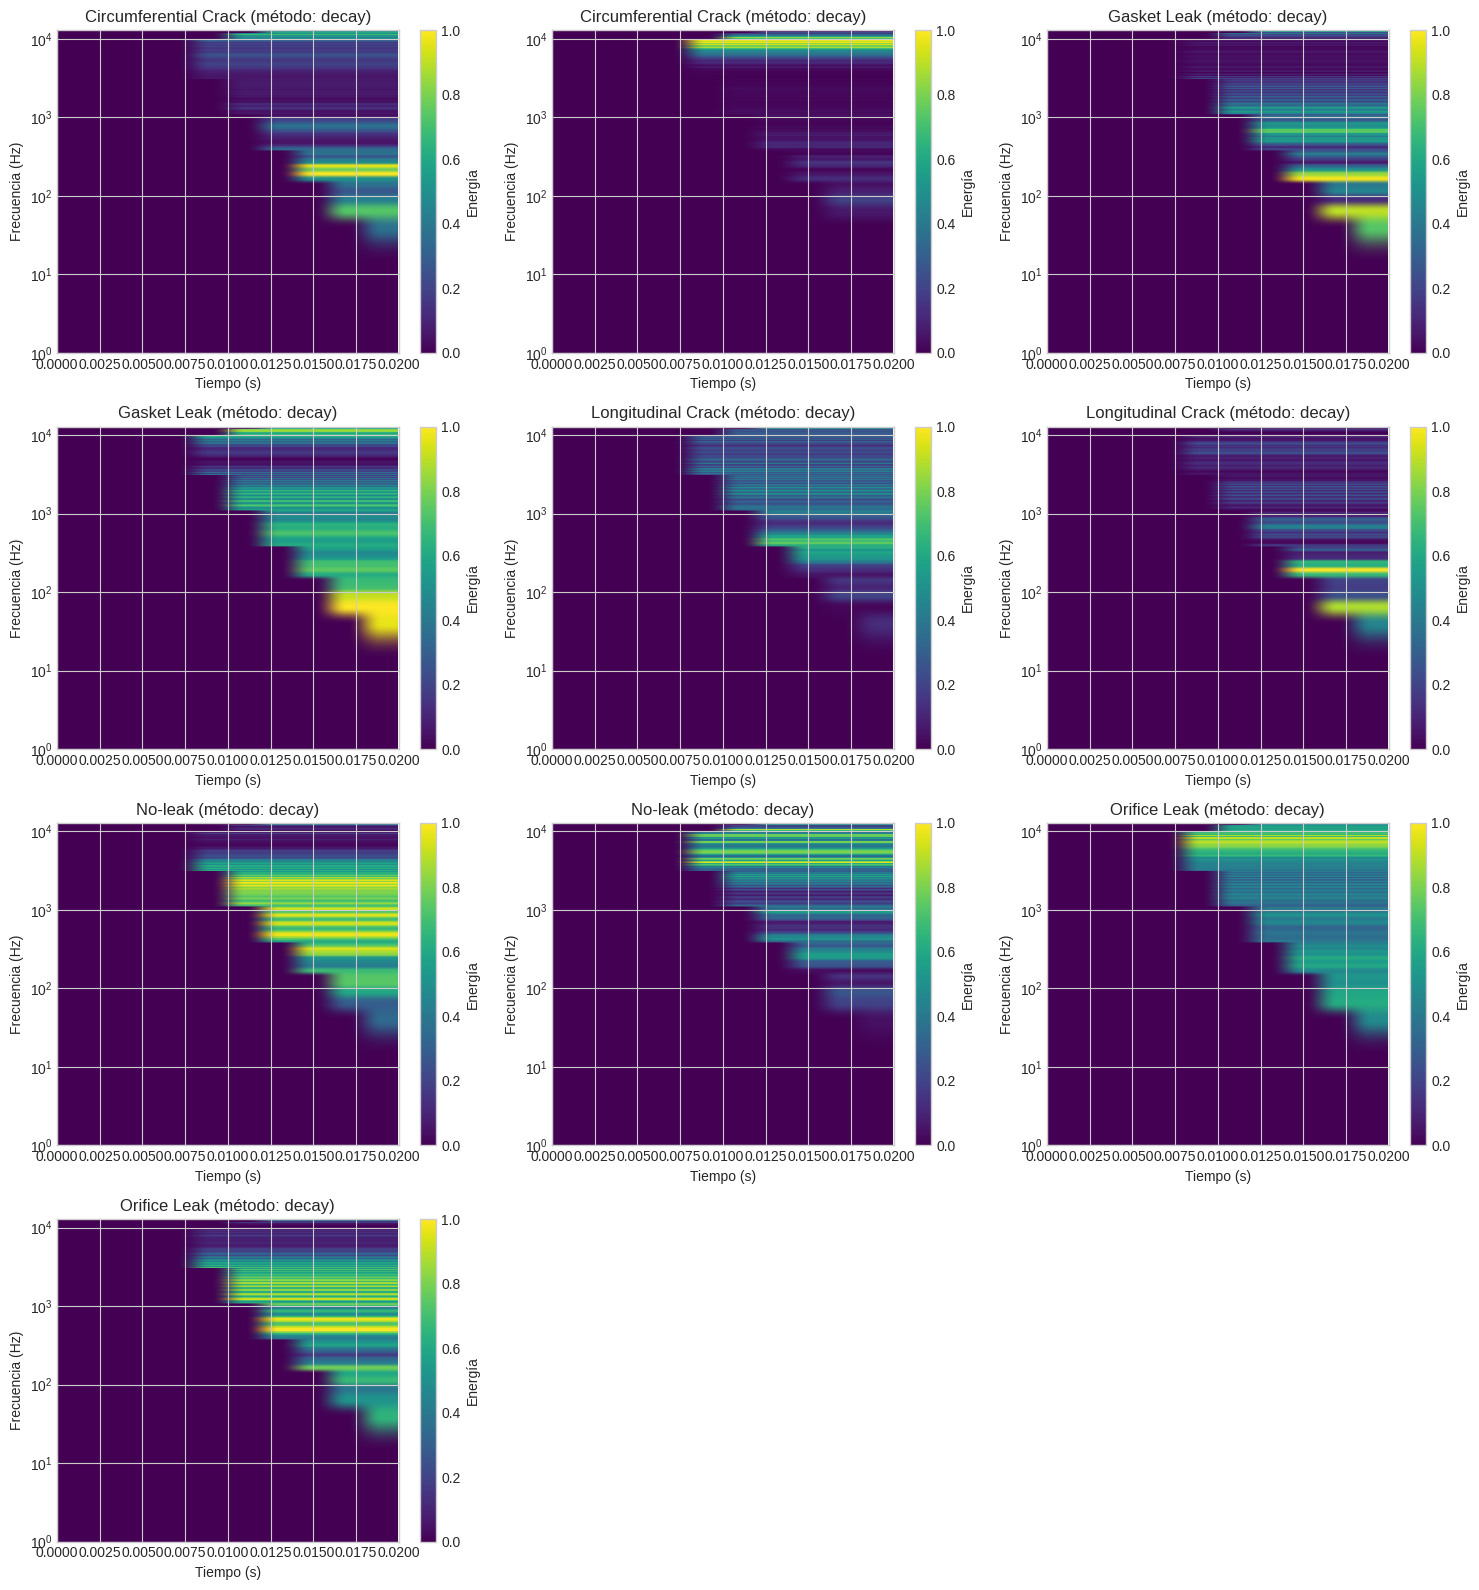

In [5]:

import numpy as np
import scipy.signal as sig
from tqdm import tqdm
import random
import math

def get_cwt_features(signals, labels, fs=25600,
                     f0=1.0, f1=None, fn=64, nthreads=1, scaling="log",
                     fast=True, norm=False, segment_size=512,
                     boundary_method='v_scalogram', pad_length=None,
                     trim_seconds=0.01):
    """
    Calcula características CWT usando fCWT con diferentes métodos de manejo de bordes,
    incluyendo V-Scalograms basados en el Cono de Influencia (COI).

    Args:
        signals: Lista de señales a procesar
        labels: Lista de etiquetas correspondientes
        fs: Frecuencia de muestreo en Hz
        f0: Frecuencia mínima
        f1: Frecuencia máxima (si es None, se usa fs/2)
        fn: Número de escalas de frecuencia
        nthreads: Número de hilos para el cálculo paralelo
        scaling: Tipo de escalado ("log", "lin", "pow")
        fast: Usar algoritmo rápido de CWT
        norm: Normalizar la salida
        segment_size: Tamaño de cada segmento en muestras
        boundary_method: Método para manejar los bordes de la señal:
                        'v_scalogram' - Usar V-Scalogram (solo coeficientes dentro del COI)
                        's_scalogram' - Usar S-Scalogram (escalograma completo, same-convolution)
                        'z_scalogram' - Usar Z-Scalogram (escalograma con valores fuera del COI puestos a cero)
                        + todos los demás métodos anteriores
        pad_length: Longitud del padding en muestras. Si es None, se calcula automáticamente
        trim_seconds: Cantidad de segundos a recortar del inicio (solo para 'none')

    Returns:
        scalograms: Lista de escalogramas
        segment_labels: Lista de etiquetas para cada escalograma
    """
    if f1 is None:
        f1 = fs/2  # Frecuencia de Nyquist

    scalograms = []
    segment_labels = []

    # Calcular longitud de padding automáticamente si no se especifica
    if pad_length is None and boundary_method not in ['none', 'v_scalogram', 's_scalogram', 'z_scalogram']:
        # Estimación basada en la frecuencia más baja
        wavelength_f0 = fs / f0  # Longitud de onda para la frecuencia más baja
        pad_length = int(wavelength_f0 / 2)  # La mitad de la longitud de onda como padding

    # Calcular número de columnas a recortar si se usa trim_seconds
    trim_points = int(trim_seconds * fs)
    trim_columns = min(int(trim_points * segment_size / fs), segment_size // 2)

    # Obtener bandas de frecuencia para el cálculo del COI
    if boundary_method in ['v_scalogram', 'z_scalogram']:
        if scaling == "log":
            frequencies = np.logspace(np.log10(f0), np.log10(f1), fn)
        elif scaling == "lin":
            frequencies = np.linspace(f0, f1, fn)
        else:  # "pow"
            frequencies = np.power(f0, 1 - np.arange(fn)/fn) * np.power(f1, np.arange(fn)/fn)

        # Calcular escalas (inversamente proporcionales a la frecuencia)
        scales = fs / (2 * np.pi * frequencies)

    # Imprimir información sobre el método usado
    print(f"Método de manejo de bordes: {boundary_method}")
    if boundary_method not in ['none', 'v_scalogram', 's_scalogram', 'z_scalogram'] and pad_length is not None:
        print(f"Longitud de padding: {pad_length} muestras")
    elif boundary_method == 'v_scalogram':
        print(f"Calculando V-Scalogram (solo coeficientes dentro del COI)")
    elif boundary_method == 's_scalogram':
        print(f"Calculando S-Scalogram (escalograma completo)")
    elif boundary_method == 'z_scalogram':
        print(f"Calculando Z-Scalogram (coeficientes fuera del COI = 0)")
    elif trim_seconds > 0:
        print(f"Recortando los primeros {trim_seconds} segundos ({trim_columns} columnas) de cada escalograma")

    # Función para aplicar padding según el método elegido
    def apply_boundary_handling(segment, method, pad_len):
        if method == 'none' or pad_len <= 0 or method in ['v_scalogram', 's_scalogram', 'z_scalogram']:
            return segment

        # Resto de métodos de manejo de bordes (igual que antes)
        if method == 'zero':
            padded = np.pad(segment, (pad_len, pad_len), 'constant', constant_values=0)
        elif method == 'value':
            padded = np.pad(segment, (pad_len, pad_len), 'edge')
        elif method == 'decay':
            padded = np.pad(segment, (pad_len, pad_len), 'constant', constant_values=0)
            decay_left = np.exp(np.linspace(0, -5, pad_len))
            padded[:pad_len] = segment[0] * decay_left
            decay_right = np.exp(np.linspace(-5, 0, pad_len))
            padded[-pad_len:] = segment[-1] * decay_right
        elif method == 'periodic':
            padded = np.pad(segment, (pad_len, pad_len), 'wrap')
        elif method == 'reflection':
            padded = np.pad(segment, (pad_len, pad_len), 'reflect')
        elif method == 'window':
            window = sig.windows.tukey(len(segment), alpha=0.25)
            windowed_segment = segment * window
            padded = np.pad(windowed_segment, (pad_len, pad_len), 'constant', constant_values=0)
        elif method == 'forecasting':
            try:
                M = min(len(segment) // 8, 64)
                processed_segment = signal_extend_forecasting(segment, pad_len, M=M)
                if len(processed_segment) != len(segment) + pad_len:
                    if len(processed_segment) < len(segment) + pad_len:
                        processed_segment = np.pad(processed_segment, (0, (len(segment) + pad_len) - len(processed_segment)), 'edge')
                    else:
                        processed_segment = processed_segment[:len(segment) + pad_len]
                padded = np.pad(processed_segment, (pad_len, 0), 'reflect')
            except Exception as e:
                print(f"Error en forecasting, usando reflection: {e}")
                padded = np.pad(segment, (pad_len, pad_len), 'reflect')
        elif method == 'poly':
            padded = np.zeros(len(segment) + 2*pad_len)
            padded[pad_len:-pad_len] = segment
            x_left = np.arange(min(10, len(segment)))
            poly_left = np.polyfit(x_left, segment[:len(x_left)], min(3, len(x_left)-1))
            x_extrap_left = np.arange(-pad_len, 0)
            padded[:pad_len] = np.polyval(poly_left, x_extrap_left)
            x_right = np.arange(min(10, len(segment)))
            poly_right = np.polyfit(x_right, segment[-len(x_right):], min(3, len(x_right)-1))
            x_extrap_right = np.arange(len(segment), len(segment)+pad_len)
            padded[-pad_len:] = np.polyval(poly_right, x_extrap_right)
        elif method == 'wraparound':
            padded = np.pad(segment, (pad_len, pad_len), 'wrap')
        else:
            raise ValueError(f"Método de manejo de bordes no reconocido: {method}")

        return padded

    # Función para calcular la máscara del Cono de Influencia (COI)
    def calculate_coi_mask(fcwt_output, scales, segment_length):
        """
        Calcula la máscara del Cono de Influencia (COI) para un escalograma.

        Args:
            fcwt_output: Matriz de coeficientes CWT (forma: [frecuencias, tiempo])
            scales: Lista de escalas utilizadas
            segment_length: Longitud del segmento original

        Returns:
            Máscara booleana del mismo tamaño que fcwt_output (True dentro del COI)
        """
        num_freqs, num_times = fcwt_output.shape
        mask = np.ones_like(fcwt_output, dtype=bool)

        # Para cada escala/frecuencia
        for i, scale in enumerate(scales):
            # El ancho del borde es proporcional a la escala
            # Utilizamos la regla práctica de que el efecto de borde
            # se extiende aproximadamente 2 veces la escala
            border_width = int(np.ceil(2.0 * scale))

            # Limitar el ancho del borde a la mitad del segmento
            border_width = min(border_width, num_times // 2)

            # Marcar regiones fuera del COI como False
            if border_width > 0:
                mask[i, :border_width] = False
                mask[i, -border_width:] = False

        return mask

    # Iterar por cada señal y su etiqueta con una barra de progreso
    for i, (signal, label) in enumerate(tqdm(zip(signals, labels), total=len(signals), desc="Calculando CWT")):
        # Calcular cuántos segmentos podemos extraer de esta señal
        num_segments = len(signal) // segment_size

        # Procesar cada segmento
        for j in range(num_segments):
            # Extraer segmento
            segment = signal[j*segment_size:(j+1)*segment_size]

            try:
                # Manejar el segmento según el método seleccionado
                if boundary_method in ['v_scalogram', 's_scalogram', 'z_scalogram']:
                    # Calculamos directamente con fCWT sin padding adicional
                    processed_segment = segment
                else:
                    # Usar los métodos tradicionales de manejo de bordes
                    processed_segment = apply_boundary_handling(segment, boundary_method, pad_length)

                # Calcular CWT con fCWT
                freqs, fcwt_output = cwt(processed_segment, fs, f0, f1, fn, nthreads, scaling, fast, norm)

                # Aplicar el método de manejo de bordes específico para escalogramas
                if boundary_method == 'v_scalogram':
                    # Calcular la máscara del COI
                    coi_mask = calculate_coi_mask(fcwt_output, scales, len(segment))

                    # Crear una lista para almacenar las filas recortadas
                    cropped_rows = []

                    # Para cada fila (frecuencia), recortar según su COI
                    for freq_idx in range(fcwt_output.shape[0]):
                        row = fcwt_output[freq_idx]
                        # Obtener índices donde la máscara es True (dentro del COI)
                        valid_indices = np.where(coi_mask[freq_idx])[0]
                        if len(valid_indices) > 0:
                            # Guardar la parte dentro del COI
                            cropped_rows.append((freq_idx, row[valid_indices]))

                    # Calcular el escalograma (potencia)
                    v_scalogram = []
                    for freq_idx, row in cropped_rows:
                        v_scalogram.append(np.square(np.abs(row)))

                    # Si no hay datos válidos (caso extremo), continuar con el siguiente segmento
                    if len(v_scalogram) == 0:
                        continue

                    # Convertir a array y transponer para tener formato [tiempo, frecuencia]
                    fcwt_scalogram = np.array(v_scalogram).T

                elif boundary_method == 'z_scalogram':
                    # Calcular la máscara del COI
                    coi_mask = calculate_coi_mask(fcwt_output, scales, len(segment))

                    # Crear Z-Scalogram: poner a cero fuera del COI
                    z_fcwt_output = fcwt_output.copy()
                    z_fcwt_output[~coi_mask] = 0

                    # Calcular el escalograma (potencia) y transponer
                    fcwt_scalogram = np.square(np.abs(z_fcwt_output)).T

                else:  # 's_scalogram' o cualquier otro método tradicional
                    # Extraer la parte central para métodos con padding
                    if boundary_method not in ['none', 's_scalogram'] and pad_length is not None:
                        orig_size = len(segment)
                        center_start = pad_length
                        center_end = center_start + orig_size
                        fcwt_output = fcwt_output[:, center_start:center_end]

                    # Calcular el escalograma (potencia) y transponer
                    fcwt_scalogram = np.square(np.abs(fcwt_output)).T

                # Recortar si es necesario (solo para método 'none')
                if boundary_method == 'none' and trim_seconds > 0:
                    if trim_columns > 0 and fcwt_scalogram.shape[0] > trim_columns * 2:
                        fcwt_scalogram = fcwt_scalogram[trim_columns:, :]

                # Normalizar
                max_val = np.max(fcwt_scalogram)
                if max_val > 0:  # Evitar división por cero
                    fcwt_scalogram = fcwt_scalogram / max_val

                # Almacenar resultados
                scalograms.append(fcwt_scalogram)
                segment_labels.append(label)

            except Exception as e:
                print(f"Error en segmento {j} de señal {i}: {e}")
                continue

    if len(scalograms) > 0:
        print(f"Escalogramas calculados: {len(scalograms)}")
        print(f"Forma de un escalograma: {scalograms[0].shape}")

    return scalograms, segment_labels

# Alternativa usando imshow (más simple y evita errores de dimensiones)
def plot_cwt_scalograms(scalograms, labels, label_codes_dict, num_per_class=2,
                        fs=25600, segment_size=512, boundary_method='none'):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm

    # Parámetros
    t_duration = segment_size / fs
    f0 = 1.0
    f1 = fs/2

    # Configurar subplot grid
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    total_plots = num_classes * num_per_class
    rows = int(np.ceil(total_plots / 3))
    cols = min(3, total_plots)

    plt.figure(figsize=(15, 4*rows))
    plot_idx = 1

    for label_code in unique_labels:
        class_indices = [i for i, l in enumerate(labels) if l == label_code]
        selected_indices = random.sample(class_indices, min(num_per_class, len(class_indices)))

        for idx in selected_indices:
            scalogram = np.array(scalograms[idx])

            # Crear subplot
            ax = plt.subplot(rows, cols, plot_idx)

            # Usar imshow en lugar de pcolormesh
            im = ax.imshow(scalogram, aspect='auto', origin='lower',
                         extent=[0, t_duration, f0, f1], cmap=cm.viridis)

            # Configurar escala logarítmica para frecuencias
            ax.set_yscale('log')

            # Etiquetas y título
            if classification_mode == 'five_classes':
                label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(label_code)]
            else:
                label_name = 'Leak' if label_code == 0 else 'No-leak'

            title = f"{label_name}"
            if boundary_method != 'none':
                title += f" (método: {boundary_method})"

            ax.set_title(title)
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Frecuencia (Hz)')

            plt.colorbar(im, ax=ax, label='Energía')
            plot_idx += 1

    plt.tight_layout()
    plt.show()

# V-Scalograms (solo coeficientes dentro del COI)
train_scalograms, train_labels = get_cwt_features(
    wavelet_denoised_signals_dict['training'],
    labels_dict['training'],
    segment_size=512,
    fn=10,
    boundary_method='z_scalogram',  # Usar V-Scalogram
    pad_length=None  # No se requiere especificar pad_length
)

test_scalograms, test_labels = get_cwt_features(
    wavelet_denoised_signals_dict['testing'],
    labels_dict['testing'],
    segment_size=512,
    fn=10,
    boundary_method='z_scalogram',
    pad_length=None
)

# Imprimir información sobre los escalogramas generados
print(f"Número de escalogramas de entrenamiento: {len(train_scalograms)}")
print(f"Número de escalogramas de prueba: {len(test_scalograms)}")
print(f"Forma de un escalograma: {train_scalograms[0].shape}")

# Visualizar algunos escalogramas de ejemplo
print("\nEscalogramas con método de reflexión:")
plot_cwt_scalograms(
    train_scalograms,
    train_labels,
    label_codes_dict,
    num_per_class=2,
    boundary_method='decay'
)

## 4.2 Recorte de Escalogramas para Eliminar Regiones de Cero

Recortando escalogramas de entrenamiento...
Recortando escalogramas de prueba...

Comparación de escalogramas originales vs. recortados:


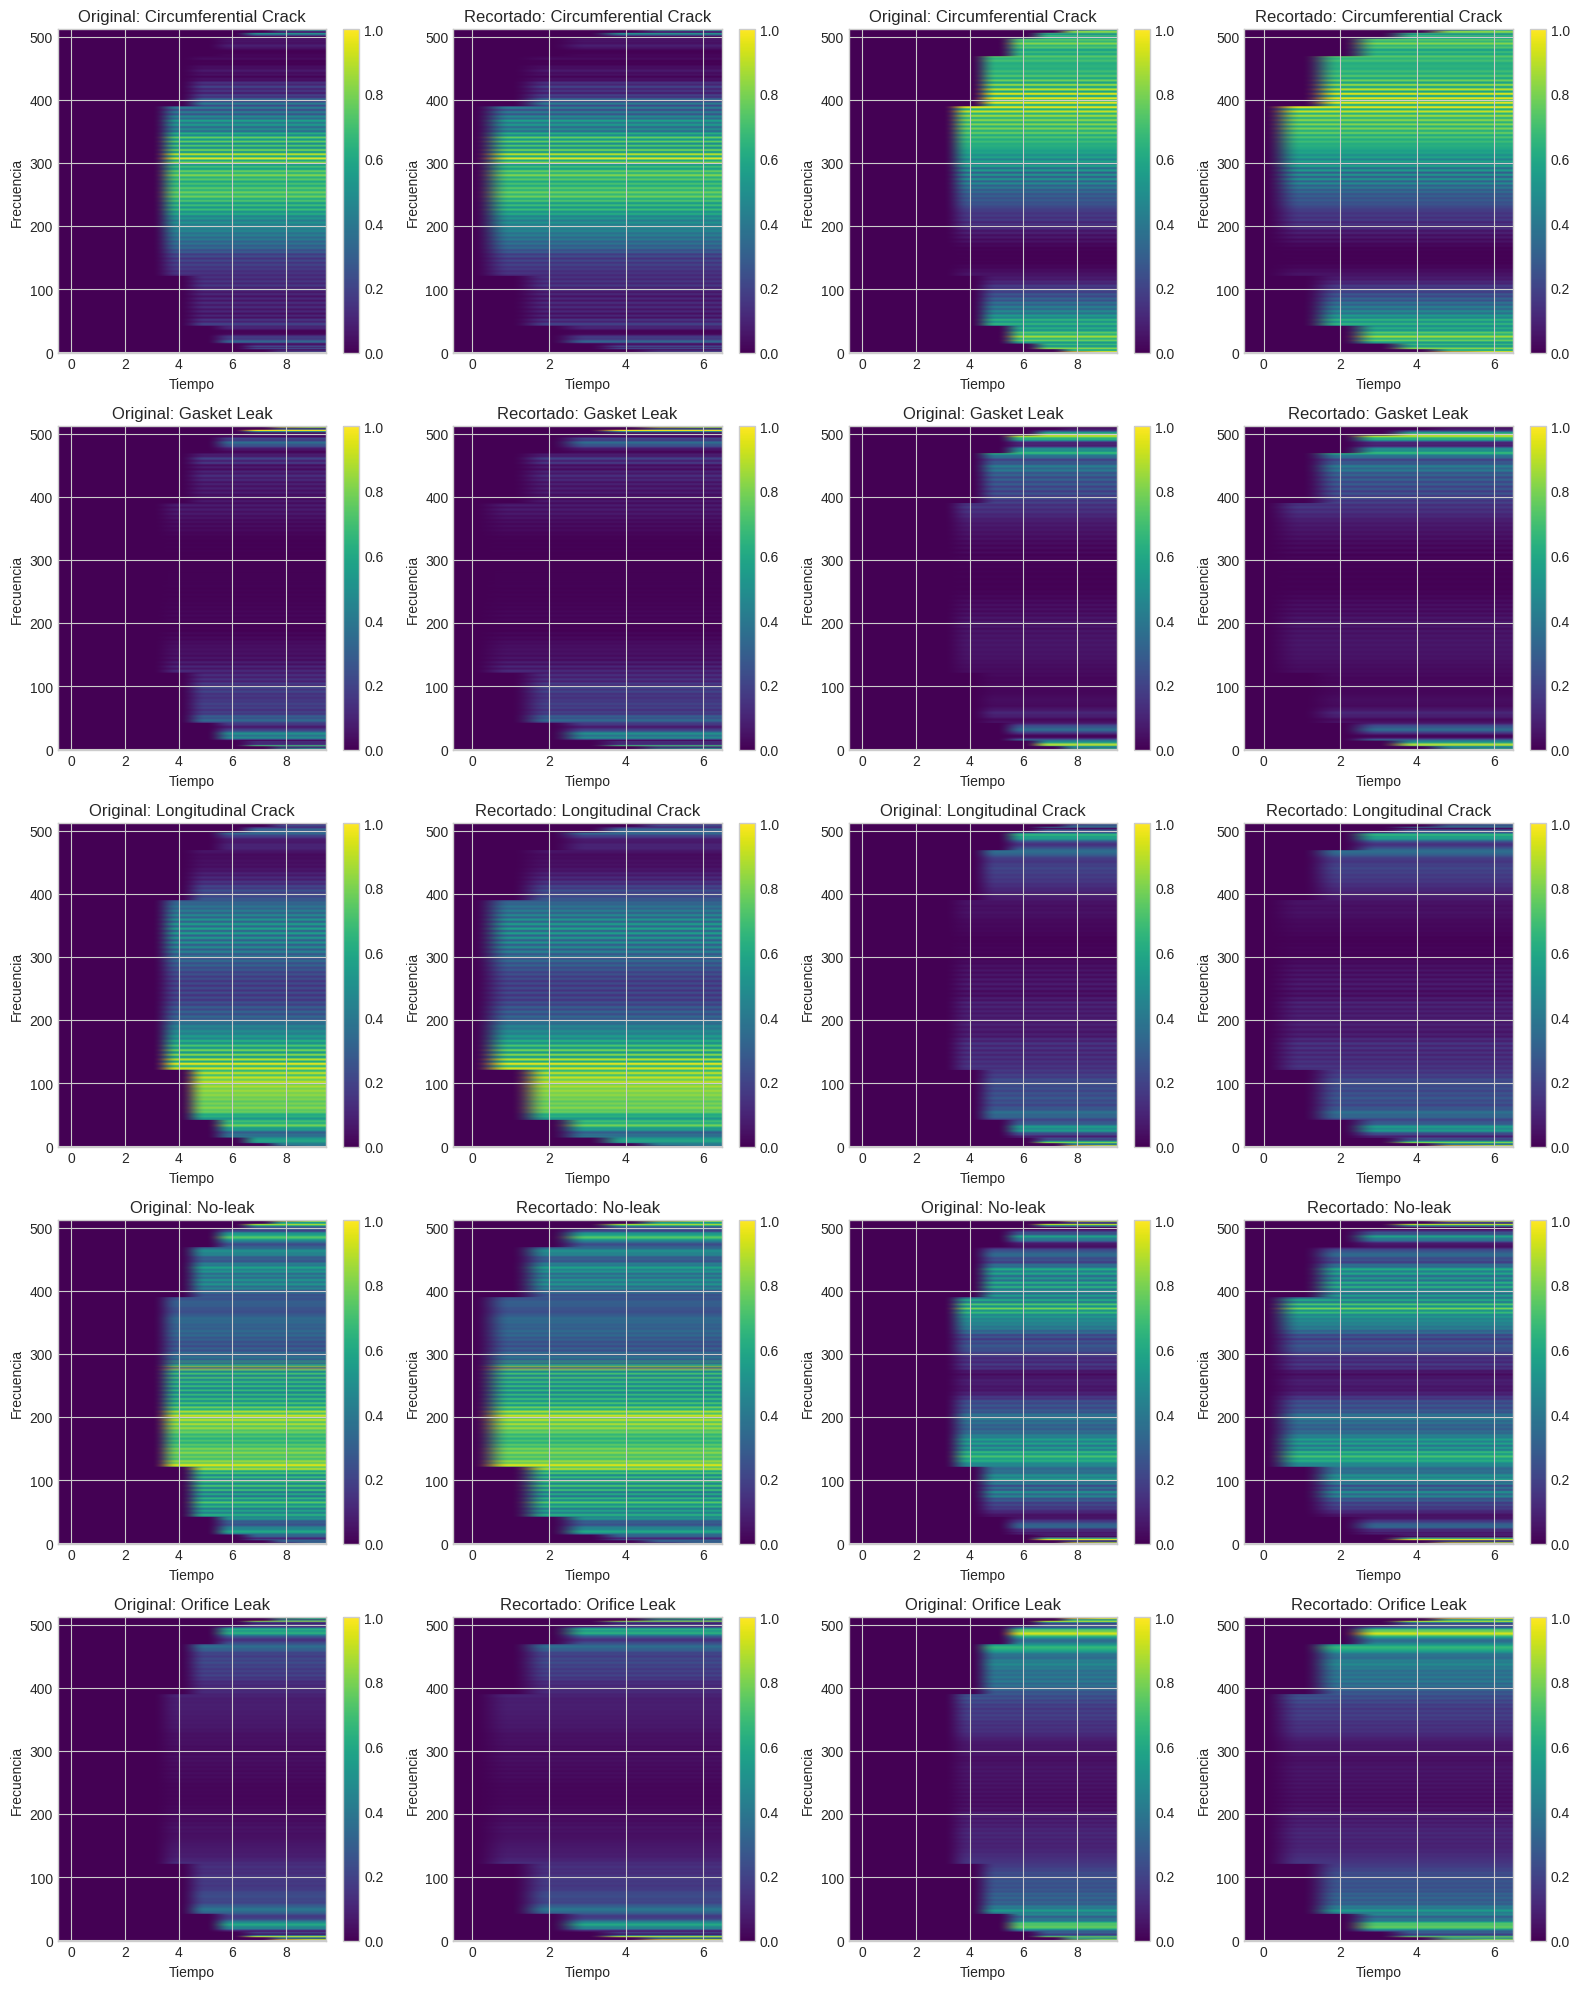

Forma original: (512, 10)
Forma recortada: (512, 7)
Reducción de tamaño: 30.00%

Escalogramas recortados listos para entrenar el modelo:
Número de escalogramas de entrenamiento: 48000
Número de escalogramas de prueba: 12000
Nueva forma de los escalogramas: (512, 7)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

def crop_zero_regions(scalograms, threshold=1e-10, padding=0):
    """
    Recorta las regiones de ceros en los escalogramas.

    Args:
        scalograms: Lista de escalogramas a recortar
        threshold: Valor por debajo del cual se considera un elemento como cero
        padding: Número de filas/columnas adicionales a mantener como margen

    Returns:
        Lista de escalogramas recortados
    """
    if len(scalograms) == 0:
        return []

    # Encontrar límites globales para recortar de manera consistente
    min_row_start = float('inf')
    max_row_end = 0
    min_col_start = float('inf')
    max_col_end = 0

    # Analizar cada escalograma para determinar los límites
    for scalogram in scalograms:
        # Encontrar filas que tienen valores significativos
        row_has_signal = np.any(scalogram > threshold, axis=1)
        if np.any(row_has_signal):
            rows_with_signal = np.where(row_has_signal)[0]
            row_start = max(0, rows_with_signal[0] - padding)
            row_end = min(scalogram.shape[0], rows_with_signal[-1] + 1 + padding)

            min_row_start = min(min_row_start, row_start)
            max_row_end = max(max_row_end, row_end)

        # Encontrar columnas que tienen valores significativos
        col_has_signal = np.any(scalogram > threshold, axis=0)
        if np.any(col_has_signal):
            cols_with_signal = np.where(col_has_signal)[0]
            col_start = max(0, cols_with_signal[0] - padding)
            col_end = min(scalogram.shape[1], cols_with_signal[-1] + 1 + padding)

            min_col_start = min(min_col_start, col_start)
            max_col_end = max(max_col_end, col_end)

    # Si no se encontraron valores significativos
    if min_row_start == float('inf') or min_col_start == float('inf'):
        return scalograms

    # Recortar todos los escalogramas con los mismos límites
    cropped_scalograms = []
    for scalogram in scalograms:
        cropped = scalogram[min_row_start:max_row_end, min_col_start:max_col_end]
        cropped_scalograms.append(cropped)

    return cropped_scalograms

def compare_original_and_cropped(original_scalograms, cropped_scalograms, labels, label_codes_dict, num_examples=2):
    """
    Visualiza una comparación entre escalogramas originales y recortados.
    """
    unique_labels = np.unique(labels)
    fig, axes = plt.subplots(len(unique_labels), 4, figsize=(16, 4*len(unique_labels)))

    for i, label_code in enumerate(unique_labels):
        # Encontrar índices de esta clase
        class_indices = [j for j, l in enumerate(labels) if l == label_code]
        if len(class_indices) == 0:
            continue

        # Seleccionar ejemplos aleatorios
        selected_indices = random.sample(class_indices, min(num_examples, len(class_indices)))

        for j, idx in enumerate(selected_indices):
            # Obtener etiqueta de texto
            if 'classification_mode' in globals() and globals()['classification_mode'] == 'five_classes':
                label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(label_code)]
            else:
                label_name = 'Leak' if label_code == 0 else 'No-leak'

            # Escalograma original
            ax = axes[i, j*2]
            im = ax.imshow(original_scalograms[idx], aspect='auto', origin='lower', cmap=cm.viridis)
            ax.set_title(f"Original: {label_name}")
            ax.set_xlabel("Tiempo")
            ax.set_ylabel("Frecuencia")
            plt.colorbar(im, ax=ax)

            # Escalograma recortado
            ax = axes[i, j*2+1]
            im = ax.imshow(cropped_scalograms[idx], aspect='auto', origin='lower', cmap=cm.viridis)
            ax.set_title(f"Recortado: {label_name}")
            ax.set_xlabel("Tiempo")
            ax.set_ylabel("Frecuencia")
            plt.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

    # Mostrar información sobre la reducción de tamaño
    orig_shape = original_scalograms[0].shape
    crop_shape = cropped_scalograms[0].shape
    orig_size = orig_shape[0] * orig_shape[1]
    crop_size = crop_shape[0] * crop_shape[1]
    reduction = (1 - crop_size/orig_size) * 100

    print(f"Forma original: {orig_shape}")
    print(f"Forma recortada: {crop_shape}")
    print(f"Reducción de tamaño: {reduction:.2f}%")

    return reduction

# Recortar los escalogramas
print("Recortando escalogramas de entrenamiento...")
cropped_train_scalograms = crop_zero_regions(train_scalograms, padding=1)

print("Recortando escalogramas de prueba...")
cropped_test_scalograms = crop_zero_regions(test_scalograms, padding=1)

# Comparar y visualizar
print("\nComparación de escalogramas originales vs. recortados:")
reduction = compare_original_and_cropped(
    train_scalograms,
    cropped_train_scalograms,
    train_labels,
    label_codes_dict
)

# Actualizar los escalogramas para usar los recortados
train_scalograms = cropped_train_scalograms
test_scalograms = cropped_test_scalograms

print("\nEscalogramas recortados listos para entrenar el modelo:")
print(f"Número de escalogramas de entrenamiento: {len(train_scalograms)}")
print(f"Número de escalogramas de prueba: {len(test_scalograms)}")
print(f"Nueva forma de los escalogramas: {train_scalograms[0].shape}")


## 5. Preparación de Datos para Modelos

In [7]:
def shuffle_coherently(scalograms, labels):
    """
    Mezcla los escalogramas y etiquetas manteniendo la correspondencia.

    Args:
        scalograms: Lista de escalogramas
        labels: Lista de etiquetas correspondientes

    Returns:
        shuffled_scalograms: Lista mezclada de escalogramas
        shuffled_labels: Lista mezclada de etiquetas correspondientes
    """
    # Crear índices y mezclarlos
    indices = np.arange(len(scalograms))
    np.random.shuffle(indices)

    # Crear listas mezcladas
    shuffled_scalograms = [scalograms[i] for i in indices]
    shuffled_labels = [labels[i] for i in indices]

    return shuffled_scalograms, shuffled_labels

def prepare_data_for_model(scalograms, labels, classification_mode):
    """
    Prepara los datos de escalogramas para el modelo CNN

    Args:
        scalograms: Lista de escalogramas
        labels: Lista de etiquetas correspondientes
        classification_mode: Modo de clasificación ('five_classes' o 'binary')

    Returns:
        x_data: Array numpy de escalogramas con canal expandido
        y_data: Array numpy de etiquetas originales
        y_onehot: Array numpy de etiquetas en formato one-hot
        num_classes: Número de clases
    """
    # Convertir a arrays numpy
    x_data = np.array(scalograms)
    y_data = np.array(labels)

    # Asegurar que los escalogramas tengan valores normalizados
    x_data = np.clip(x_data, 0, 1)

    # Expandir dimensión para canal (necesario para CNN)
    x_data = np.expand_dims(x_data, axis=-1)

    # Determinar número de clases según el modo
    if classification_mode == 'five_classes':
        num_classes = 5
    else:  # binary
        num_classes = 2

    # One-hot encoding de las etiquetas
    y_onehot = tf.keras.utils.to_categorical(y_data, num_classes)

    return x_data, y_data, y_onehot, num_classes

# Mezclar los datos de entrenamiento y prueba
shuffled_train_scalograms, shuffled_train_labels = shuffle_coherently(train_scalograms, train_labels)
shuffled_test_scalograms, shuffled_test_labels = shuffle_coherently(test_scalograms, test_labels)

# Preparar datos para el modelo
x_train, y_train, y_train_onehot, num_classes = prepare_data_for_model(
    shuffled_train_scalograms,
    shuffled_train_labels,
    classification_mode
)

x_test, y_test, y_test_onehot, _ = prepare_data_for_model(
    shuffled_test_scalograms,
    shuffled_test_labels,
    classification_mode
)

# Dividir los datos de entrenamiento en entrenamiento y validación
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train,
    y_train,
    test_size=0.2,
    stratify=y_train,  # Para mantener la proporción de clases
    random_state=42
)

# Convertir etiquetas de validación a one-hot
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes)

# Imprimir información sobre los datos preparados
print(f'x_train shape: {x_train.shape}')
print(f'x_train_final shape: {x_train_final.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'Number of classes: {num_classes}')

x_train shape: (48000, 512, 7, 1)
x_train_final shape: (38400, 512, 7, 1)
x_val shape: (9600, 512, 7, 1)
x_test shape: (12000, 512, 7, 1)
Number of classes: 5


## 5.2 Salvando el dataset

In [ ]:
# 5.1 Guardar Dataset de Escalogramas en Google Drive

def save_cwt_dataset(save_path, x_train, y_train, y_train_onehot,
                     x_val, y_val, y_val_onehot,
                     x_test, y_test, y_test_onehot,
                     num_classes, classification_mode):
    """
    Guarda el dataset de escalogramas procesados en Google Drive.

    Args:
        save_path: Ruta donde guardar el dataset
        x_train, y_train, y_train_onehot: Datos de entrenamiento
        x_val, y_val, y_val_onehot: Datos de validación
        x_test, y_test, y_test_onehot: Datos de prueba
        num_classes: Número de clases
        classification_mode: Modo de clasificación ('five_classes' o 'binary')
    """
    # Crear directorio si no existe
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Guardar datos usando formato HDF5
    with h5py.File(save_path, 'w') as hf:
        # Guardar datos de entrenamiento
        train_group = hf.create_group('train')
        train_group.create_dataset('x_train', data=x_train, compression='gzip', compression_opts=9)
        train_group.create_dataset('y_train', data=y_train, compression='gzip', compression_opts=9)
        train_group.create_dataset('y_train_onehot', data=y_train_onehot, compression='gzip', compression_opts=9)

        # Guardar datos de validación
        val_group = hf.create_group('val')
        val_group.create_dataset('x_val', data=x_val, compression='gzip', compression_opts=9)
        val_group.create_dataset('y_val', data=y_val, compression='gzip', compression_opts=9)
        val_group.create_dataset('y_val_onehot', data=y_val_onehot, compression='gzip', compression_opts=9)

        # Guardar datos de prueba
        test_group = hf.create_group('test')
        test_group.create_dataset('x_test', data=x_test, compression='gzip', compression_opts=9)
        test_group.create_dataset('y_test', data=y_test, compression='gzip', compression_opts=9)
        test_group.create_dataset('y_test_onehot', data=y_test_onehot, compression='gzip', compression_opts=9)

        # Guardar metadatos
        metadata = hf.create_group('metadata')
        metadata.attrs['num_classes'] = num_classes
        metadata.attrs['classification_mode'] = classification_mode

        # Guardar información de las formas de los datos
        shapes = hf.create_group('shapes')
        shapes.attrs['x_train_shape'] = x_train.shape
        shapes.attrs['x_val_shape'] = x_val.shape
        shapes.attrs['x_test_shape'] = x_test.shape

    print(f"Dataset guardado en: {save_path}")
    print(f"Tamaño total del dataset: {os.path.getsize(save_path) / (1024*1024):.2f} MB")

    # Guardar también información de clases
    if 'label_codes_dict' in globals():
        with open(save_path.replace('.h5', '_classes.txt'), 'w') as f:
            for class_name, class_id in label_codes_dict.items():
                f.write(f"{class_name}: {class_id}\n")

# Ruta para guardar el dataset
save_path = '/content/drive/MyDrive/Tesis/Datasets/cwt_scalograms_dataset_pywt.h5'

# Guardar el dataset completo
save_cwt_dataset(
    save_path,
    x_train, y_train, y_train_onehot,
    x_val, y_val, y_val_onehot,
    x_test, y_test, y_test_onehot,
    num_classes, classification_mode
)

Dataset guardado en: /content/drive/MyDrive/Tesis/Datasets/cwt_scalograms_dataset_pywt.h5
Tamaño total del dataset: 2106.30 MB


## 5.3 Cargando el dataset

In [ ]:
# 5.2 Cargar Dataset de Escalogramas desde Google Drive

def load_cwt_dataset(load_path):
    """
    Carga el dataset de escalogramas procesados desde Google Drive.

    Args:
        load_path: Ruta del archivo del dataset a cargar

    Returns:
        Diccionario con todos los datos y metadatos del dataset
    """
    dataset = {}

    # Verificar si el archivo existe
    if not os.path.exists(load_path):
        print(f"Error: El archivo {load_path} no existe.")
        return None

    # Cargar desde archivo HDF5
    with h5py.File(load_path, 'r') as hf:
        # Cargar datos de entrenamiento
        dataset['x_train'] = hf['train/x_train'][:]
        dataset['y_train'] = hf['train/y_train'][:]
        dataset['y_train_onehot'] = hf['train/y_train_onehot'][:]

        # Cargar datos de validación
        dataset['x_val'] = hf['val/x_val'][:]
        dataset['y_val'] = hf['val/y_val'][:]
        dataset['y_val_onehot'] = hf['val/y_val_onehot'][:]

        # Cargar datos de prueba
        dataset['x_test'] = hf['test/x_test'][:]
        dataset['y_test'] = hf['test/y_test'][:]
        dataset['y_test_onehot'] = hf['test/y_test_onehot'][:]

        # Cargar metadatos
        dataset['num_classes'] = hf['metadata'].attrs['num_classes']
        dataset['classification_mode'] = hf['metadata'].attrs['classification_mode']

        # Cargar información de formas
        dataset['shapes'] = {
            'x_train_shape': hf['shapes'].attrs['x_train_shape'],
            'x_val_shape': hf['shapes'].attrs['x_val_shape'],
            'x_test_shape': hf['shapes'].attrs['x_test_shape']
        }

    # Cargar información de clases si existe
    classes_file = load_path.replace('.h5', '_classes.txt')
    if os.path.exists(classes_file):
        label_codes = {}
        with open(classes_file, 'r') as f:
            for line in f:
                name, id_str = line.strip().split(': ')
                label_codes[name] = int(id_str)
        dataset['label_codes_dict'] = label_codes

    print(f"Dataset cargado desde: {load_path}")
    print(f"Información del dataset:")
    print(f"- Modo de clasificación: {dataset['classification_mode']}")
    print(f"- Número de clases: {dataset['num_classes']}")
    print(f"- Muestras de entrenamiento: {len(dataset['x_train'])}")
    print(f"- Muestras de validación: {len(dataset['x_val'])}")
    print(f"- Muestras de prueba: {len(dataset['x_test'])}")
    print(f"- Forma de los datos: {dataset['shapes']['x_train_shape']}")

    # Establecer variables globales para facilitar el uso
    globals().update({
        'x_train_final': dataset['x_train'],
        'y_train_final': dataset['y_train'],
        'y_train_onehot': dataset['y_train_onehot'],
        'x_val': dataset['x_val'],
        'y_val': dataset['y_val'],
        'y_val_onehot': dataset['y_val_onehot'],
        'x_test': dataset['x_test'],
        'y_test': dataset['y_test'],
        'y_test_onehot': dataset['y_test_onehot'],
        'num_classes': dataset['num_classes'],
        'classification_mode': dataset['classification_mode']
    })

    if 'label_codes_dict' in dataset:
        globals()['label_codes_dict'] = dataset['label_codes_dict']

    return dataset

# Ruta para cargar el dataset
load_path = '/content/drive/MyDrive/Tesis/Datasets/cwt_scalograms_dataset.h5'

# Cargar el dataset (descomenta esta línea cuando necesites cargar los datos)
dataset = load_cwt_dataset(load_path)

# Verificar algunas muestras cargadas (descomentar cuando sea necesario)
# if 'dataset' in locals():
#     plt.figure(figsize=(15, 6))
#     for i in range(3):
#         plt.subplot(1, 3, i+1)
#         plt.imshow(x_train[i, :, :, 0], cmap='viridis')
#         class_index = y_train[i]
#         class_names = list(label_codes_dict.keys())
#         class_name = class_names[class_index] if classification_mode == 'five_classes' else ('Leak' if class_index == 0 else 'No-leak')
#         plt.title(f'Clase: {class_name}')
#     plt.tight_layout()
#     plt.show()

Dataset cargado desde: /content/drive/MyDrive/Tesis/Datasets/cwt_scalograms_dataset.h5
Información del dataset:
- Modo de clasificación: five_classes
- Número de clases: 5
- Muestras de entrenamiento: 48000
- Muestras de validación: 9600
- Muestras de prueba: 12000
- Forma de los datos: [48000   512    13     1]


## 6. Modelo ResNet-18 con Regularización y Entrenamiento

In [ ]:
# Función de aumento de datos para escalogramas
def apply_scalogram_augmentation(scalograms, labels):
    """
    Aplica aumentación de datos a escalogramas.
    """
    augmented_scalograms = []
    augmented_labels = []

    for i, scalogram in enumerate(scalograms):
        # Original
        augmented_scalograms.append(scalogram)
        augmented_labels.append(labels[i])

        # Técnica 1: Desplazamiento de frecuencia (simula variaciones en frecuencia)
        freq_shift = np.roll(scalogram, np.random.randint(-3, 3), axis=0)
        augmented_scalograms.append(freq_shift)
        augmented_labels.append(labels[i])

        # Técnica 2: Desplazamiento de tiempo (simula grabaciones en diferente momento)
        time_shift = np.roll(scalogram, np.random.randint(-5, 5), axis=1)
        augmented_scalograms.append(time_shift)
        augmented_labels.append(labels[i])

        # Técnica 3: Agregar ruido Gaussiano (simula ruido ambiental)
        noise = np.random.normal(0, 0.05, scalogram.shape)
        noisy_scalogram = scalogram + noise
        noisy_scalogram = np.clip(noisy_scalogram, 0, 1)  # Mantener en rango [0,1]
        augmented_scalograms.append(noisy_scalogram)
        augmented_labels.append(labels[i])

        # Técnica 4: Escalogram Masking (máscara regiones del escalograma)
        mask_scalogram = scalogram.copy()
        # Máscara en frecuencia
        f_mask_size = np.random.randint(1, 5)
        f_start = np.random.randint(0, scalogram.shape[0] - f_mask_size)
        mask_scalogram[f_start:f_start+f_mask_size, :] = 0
        # Máscara en tiempo
        t_mask_size = np.random.randint(1, 10)
        t_start = np.random.randint(0, scalogram.shape[1] - t_mask_size)
        mask_scalogram[:, t_start:t_start+t_mask_size] = 0
        augmented_scalograms.append(mask_scalogram)
        augmented_labels.append(labels[i])

    return np.array(augmented_scalograms), np.array(augmented_labels)

# Implementación del bloque residual
def residual_block_with_reg(x, filters, kernel_size=3, stride=1, conv_shortcut=False, reg=None):
    """
    Bloque residual con regularización
    """
    shortcut = x

    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', kernel_regularizer=reg)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)


    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.ReLU()(x)

    return x

# Función para construir el modelo ResNet18 regularizado
def build_cwt_resnet18_with_regularization(input_shape, num_classes=5):
    """
    Construye un modelo ResNet18 con regularización para escalogramas CWT

    Args:
        input_shape: Forma de entrada (alto, ancho, canales)
        num_classes: Número de clases

    Returns:
        model: Modelo compilado
    """
    inputs = layers.Input(shape=input_shape)

    # Regularizador L2
    reg = keras.regularizers.l2(0.001)

    # Bloque inicial con regularización
    x = layers.Conv2D(64, 7, strides=2, padding='same', kernel_regularizer=reg)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    x = layers.Dropout(0.2)(x)  # Dropout después del primer bloque

    # ResNet bloques con regularización
    x = residual_block_with_reg(x, 64, reg=reg)
    x = residual_block_with_reg(x, 64, reg=reg)
    x = layers.Dropout(0.3)(x)

    x = residual_block_with_reg(x, 128, stride=2, conv_shortcut=True, reg=reg)
    x = residual_block_with_reg(x, 128, reg=reg)
    x = layers.Dropout(0.3)(x)

    x = residual_block_with_reg(x, 256, stride=2, conv_shortcut=True, reg=reg)
    x = residual_block_with_reg(x, 256, reg=reg)
    x = layers.Dropout(0.4)(x)

    x = residual_block_with_reg(x, 512, stride=2, conv_shortcut=True, reg=reg)
    x = residual_block_with_reg(x, 512, reg=reg)

    # Capa de clasificación
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=reg)(x)
    x = layers.Dropout(0.5)(x)

    # Capa de salida según el número de clases
    if num_classes == 2:  # Clasificación binaria
        outputs = layers.Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
    else:  # Clasificación multiclase
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        loss = 'categorical_crossentropy'

    model = keras.Model(inputs, outputs, name="cwt_resnet18_regularized")

    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss=loss,
        metrics=['accuracy']
    )

    return model

# Crear modelo regularizado
model_reg = build_cwt_resnet18_with_regularization(x_train.shape[1:], num_classes)

# Mostrar resumen del modelo
model_reg.summary()

# Aplicar data augmentation (opcional)
use_augmentation = False # Cambia a False para desactivar

if use_augmentation:
    augmented_x_train, augmented_y_train = apply_scalogram_augmentation(x_train_final, y_train_final)
    print(f"Tamaño original: {len(x_train_final)}, Tamaño aumentado: {len(augmented_x_train)}")

    # One-hot encoding de las etiquetas aumentadas
    if num_classes > 2:
        augmented_y_train_onehot = tf.keras.utils.to_categorical(augmented_y_train, num_classes)
    else:
        augmented_y_train_onehot = augmented_y_train

    # Entrenar con datos aumentados
    x_train_to_use = augmented_x_train
    y_train_to_use = augmented_y_train_onehot
else:
    # Entrenar con datos originales
    x_train_to_use = x_train_final
    # Use y_train_final_onehot instead of y_train_onehot
    y_train_final_onehot = tf.keras.utils.to_categorical(y_train_final, num_classes) # create one-hot encoding for final training labels
    y_train_to_use = y_train_final_onehot

# Definir warmup_schedule para la tasa de aprendizaje
def warmup_schedule(epoch, lr):
    warmup_epochs = 5
    init_lr = 1e-6
    target_lr = 0.0005

    if epoch < warmup_epochs:
        return init_lr + (target_lr - init_lr) * epoch / warmup_epochs
    return lr

# Callbacks mejorados
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=8,
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/Tesis/Models/cwt_resnet18_reg.h5',
        monitor='val_accuracy',
        save_best_only=True
    ),
    keras.callbacks.LearningRateScheduler(warmup_schedule)
]

# Entrenamiento
batch_size = 32
epochs = 200

# Entrenar el modelo con datos aumentados
history = model_reg.fit(
    x_train_to_use,
    y_train_to_use,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val_onehot),
    callbacks=callbacks,
    verbose=1
)

# Evaluar el modelo en conjunto de prueba
if num_classes == 2:
    test_loss, test_accuracy = model_reg.evaluate(x_test, y_test)
else:
    test_loss, test_accuracy = model_reg.evaluate(x_test, y_test_onehot)

print(f'Test accuracy: {test_accuracy:.4f}')

# Visualizar resultados del entrenamiento
plt.figure(figsize=(12, 4))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calcular matriz de confusión y métricas de rendimiento
if num_classes == 2:
    y_pred_prob = model_reg.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    class_names = ['Leak', 'No-leak']
else:
    y_pred_prob = model_reg.predict(x_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    if classification_mode == 'five_classes':
        class_names = list(label_codes_dict.keys())
    else:
        class_names = ['Leak', 'No-leak']

# Visualizar matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Imprimir reporte de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Model: "cwt_resnet18_regularized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 7, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 4, 64)     │          3,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 4, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 4, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 2, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 2, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 2, 64)     │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 2, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128, 2, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 2, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 2, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 2, 64)     │              0 │ dropout[0][0],         │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 128, 2, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 2, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 2, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 128, 2, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)    

 Total params: 11,449,861 (43.68 MB)

 Trainable params: 11,440,261 (43.64 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2064 - loss: 6.4852

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 93s 43ms/step - accuracy: 0.2064 - loss: 6.4851 - val_accuracy: 0.1963 - val_loss: 6.0255 - learning_rate: 1.0000e-06
Epoch 2/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2316 - loss: 4.5799

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.2316 - loss: 4.5795 - val_accuracy: 0.2810 - val_loss: 3.7232 - learning_rate: 1.0080e-04
Epoch 3/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2661 - loss: 3.5641

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.2661 - loss: 3.5638 - val_accuracy: 0.2872 - val_loss: 3.0529 - learning_rate: 2.0060e-04
Epoch 4/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2740 - loss: 2.8258

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 88s 40ms/step - accuracy: 0.2740 - loss: 2.8254 - val_accuracy: 0.2968 - val_loss: 2.2455 - learning_rate: 3.0040e-04
Epoch 5/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 73s 32ms/step - accuracy: 0.2866 - loss: 2.0985 - val_accuracy: 0.2961 - val_loss: 1.7665 - learning_rate: 4.0020e-04
Epoch 6/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.3070 - loss: 1.7281 - val_accuracy: 0.2668 - val_loss: 1.6598 - learning_rate: 4.0020e-04
Epoch 7/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3113 - loss: 1.6165

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 47s 36ms/step - accuracy: 0.3113 - loss: 1.6165 - val_accuracy: 0.3132 - val_loss: 1.5923 - learning_rate: 4.0020e-04
Epoch 8/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 77s 32ms/step - accuracy: 0.2989 - loss: 1.5989 - val_accuracy: 0.2927 - val_loss: 1.5899 - learning_rate: 4.0020e-04
Epoch 9/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.2907 - loss: 1.6005 - val_accuracy: 0.3044 - val_loss: 1.5838 - learning_rate: 4.0020e-04
Epoch 10/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.2964 - loss: 1.5919 - val_accuracy: 0.2402 - val_loss: 1.6839 - learning_rate: 4.0020e-04
Epoch 11/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.3020 - loss: 1.5918 - val_accuracy: 0.2565 - val_loss: 1.6262 - learning_rate: 4.0020e-04
Epoch 12/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.2938 - loss: 1.5940 - val_accuracy: 0.2907 - val_loss: 1.5946 - learning_rate: 4.0020e-04
Epoch 13/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.2990 - loss: 1.5778 - val_accuracy: 0.3214 - val_loss: 1.5814 - learning_rate: 4.0020e-04
Epoch 19/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - accuracy: 0.3157 - loss: 1.5746 - val_accuracy: 0.3076 - val_loss: 1.5736 - learning_rate: 4.0020e-04
Epoch 20/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.3199 - loss: 1.5699 - val_accuracy: 0.3032 - val_loss: 1.5756 - learning_rate: 4.0020e-04
Epoch 21/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.3092 - loss: 1.5707 - val_accuracy: 0.3084 - val_loss: 1.5746 - learning_rate: 4.0020e-04
Epoch 22/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.3133 - loss: 1.5713 - val_accuracy: 0.2594 - val_loss: 1.6429 - learning_rate: 4.0020e-04
Epoch 23/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3088 - loss: 1.5664

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.3088 - loss: 1.5664 - val_accuracy: 0.3225 - val_loss: 1.5703 - learning_rate: 4.0020e-04
Epoch 24/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.3190 - loss: 1.5664 - val_accuracy: 0.2136 - val_loss: 2.0636 - learning_rate: 4.0020e-04
Epoch 25/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.3135 - loss: 1.5620 - val_accuracy: 0.2741 - val_loss: 1.8227 - learning_rate: 4.0020e-04
Epoch 26/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.3189 - loss: 1.5612 - val_accuracy: 0.2536 - val_loss: 1.7676 - learning_rate: 4.0020e-04
Epoch 27/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3214 - loss: 1.5605

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 46s 38ms/step - accuracy: 0.3214 - loss: 1.5605 - val_accuracy: 0.3264 - val_loss: 1.5811 - learning_rate: 4.0020e-04
Epoch 28/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 75s 33ms/step - accuracy: 0.3160 - loss: 1.5597 - val_accuracy: 0.2961 - val_loss: 1.5642 - learning_rate: 4.0020e-04
Epoch 29/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3236 - loss: 1.5492

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.3236 - loss: 1.5492 - val_accuracy: 0.3295 - val_loss: 1.5478 - learning_rate: 4.0020e-04
Epoch 30/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 76s 33ms/step - accuracy: 0.3216 - loss: 1.5532 - val_accuracy: 0.3166 - val_loss: 1.5498 - learning_rate: 4.0020e-04
Epoch 31/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.3200 - loss: 1.5494 - val_accuracy: 0.2621 - val_loss: 1.6327 - learning_rate: 4.0020e-04
Epoch 32/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.3228 - loss: 1.5511 - val_accuracy: 0.3090 - val_loss: 1.5855 - learning_rate: 4.0020e-04
Epoch 33/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.3256 - loss: 1.5486 - val_accuracy: 0.2222 - val_loss: 1.7879 - learning_rate: 4.0020e-04
Epoch 34/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.3178 - loss: 1.5503 - val_accuracy: 0.2640 - val_loss: 1.6202 - learning_rate: 4.0020e-04
Epoch 35/200
1200/1200 ━━━━━━━━━━━━━━━━━━

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 44s 34ms/step - accuracy: 0.3328 - loss: 1.5286 - val_accuracy: 0.3551 - val_loss: 1.4992 - learning_rate: 8.0040e-05
Epoch 39/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3409 - loss: 1.5146

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.3409 - loss: 1.5146 - val_accuracy: 0.3557 - val_loss: 1.4938 - learning_rate: 8.0040e-05
Epoch 40/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.3372 - loss: 1.5174 - val_accuracy: 0.3556 - val_loss: 1.4913 - learning_rate: 8.0040e-05
Epoch 41/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3432 - loss: 1.5057

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.3432 - loss: 1.5057 - val_accuracy: 0.3616 - val_loss: 1.4811 - learning_rate: 8.0040e-05
Epoch 42/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.3405 - loss: 1.5049 - val_accuracy: 0.3493 - val_loss: 1.4914 - learning_rate: 8.0040e-05
Epoch 43/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.3488 - loss: 1.5028 - val_accuracy: 0.3541 - val_loss: 1.4811 - learning_rate: 8.0040e-05
Epoch 44/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.3438 - loss: 1.5022 - val_accuracy: 0.3476 - val_loss: 1.4846 - learning_rate: 8.0040e-05
Epoch 45/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.3456 - loss: 1.5023 - val_accuracy: 0.3570 - val_loss: 1.4817 - learning_rate: 8.0040e-05
Epoch 46/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.3486 - loss: 1.4966 - val_accuracy: 0.3415 - val_loss: 1.4981 - learning_rate: 8.0040e-05
Epoch 47/200
1200/1200 ━━━━━━━━━━━━━━━━━━

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.3523 - loss: 1.4897 - val_accuracy: 0.3639 - val_loss: 1.4670 - learning_rate: 1.6008e-05
Epoch 51/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.3557 - loss: 1.4867 - val_accuracy: 0.3622 - val_loss: 1.4655 - learning_rate: 1.6008e-05
Epoch 52/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.3585 - loss: 1.4818 - val_accuracy: 0.3633 - val_loss: 1.4592 - learning_rate: 1.6008e-05
Epoch 53/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3555 - loss: 1.4810

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - accuracy: 0.3555 - loss: 1.4810 - val_accuracy: 0.3650 - val_loss: 1.4581 - learning_rate: 1.6008e-05
Epoch 54/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3575 - loss: 1.4768

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - accuracy: 0.3575 - loss: 1.4768 - val_accuracy: 0.3669 - val_loss: 1.4554 - learning_rate: 1.6008e-05
Epoch 55/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3606 - loss: 1.4779

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 76s 34ms/step - accuracy: 0.3606 - loss: 1.4779 - val_accuracy: 0.3685 - val_loss: 1.4566 - learning_rate: 1.6008e-05
Epoch 56/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 80s 32ms/step - accuracy: 0.3673 - loss: 1.4688 - val_accuracy: 0.3664 - val_loss: 1.4529 - learning_rate: 1.6008e-05
Epoch 57/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.3626 - loss: 1.4704 - val_accuracy: 0.3665 - val_loss: 1.4523 - learning_rate: 1.6008e-05
Epoch 58/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.3661 - loss: 1.4688 - val_accuracy: 0.3673 - val_loss: 1.4480 - learning_rate: 1.6008e-05
Epoch 59/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3660 - loss: 1.4671

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 44s 37ms/step - accuracy: 0.3660 - loss: 1.4671 - val_accuracy: 0.3701 - val_loss: 1.4462 - learning_rate: 1.6008e-05
Epoch 60/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.3684 - loss: 1.4655 - val_accuracy: 0.3647 - val_loss: 1.4508 - learning_rate: 1.6008e-05
Epoch 61/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.3704 - loss: 1.4588 - val_accuracy: 0.3671 - val_loss: 1.4428 - learning_rate: 1.6008e-05
Epoch 62/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3709 - loss: 1.4623

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.3709 - loss: 1.4623 - val_accuracy: 0.3719 - val_loss: 1.4435 - learning_rate: 1.6008e-05
Epoch 63/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3669 - loss: 1.4631

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 83s 37ms/step - accuracy: 0.3669 - loss: 1.4631 - val_accuracy: 0.3728 - val_loss: 1.4383 - learning_rate: 1.6008e-05
Epoch 64/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3682 - loss: 1.4576

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 84s 39ms/step - accuracy: 0.3682 - loss: 1.4576 - val_accuracy: 0.3740 - val_loss: 1.4411 - learning_rate: 1.6008e-05
Epoch 65/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 72s 31ms/step - accuracy: 0.3727 - loss: 1.4566 - val_accuracy: 0.3713 - val_loss: 1.4485 - learning_rate: 1.6008e-05
Epoch 66/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.3700 - loss: 1.4580 - val_accuracy: 0.3721 - val_loss: 1.4360 - learning_rate: 1.6008e-05
Epoch 67/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.3736 - loss: 1.4557 - val_accuracy: 0.3734 - val_loss: 1.4337 - learning_rate: 1.6008e-05
Epoch 68/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3773 - loss: 1.4482

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.3773 - loss: 1.4482 - val_accuracy: 0.3775 - val_loss: 1.4287 - learning_rate: 1.6008e-05
Epoch 69/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.3707 - loss: 1.4504 - val_accuracy: 0.3749 - val_loss: 1.4331 - learning_rate: 1.6008e-05
Epoch 70/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.3720 - loss: 1.4540 - val_accuracy: 0.3520 - val_loss: 1.4646 - learning_rate: 1.6008e-05
Epoch 71/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.3705 - loss: 1.4535 - val_accuracy: 0.3748 - val_loss: 1.4325 - learning_rate: 1.6008e-05
Epoch 72/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.3783 - loss: 1.4456 - val_accuracy: 0.3742 - val_loss: 1.4301 - learning_rate: 1.6008e-05
Epoch 73/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.3759 - loss: 1.4429 - val_accuracy: 0.3772 - val_loss: 1.4315 - learning_rate: 1.6008e-05
Epoch 74/200
1199/1200 ━━━━━━━━━━━━━━━━━━

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.3792 - loss: 1.4432 - val_accuracy: 0.3812 - val_loss: 1.4270 - learning_rate: 1.6008e-05
Epoch 75/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 74s 31ms/step - accuracy: 0.3702 - loss: 1.4500 - val_accuracy: 0.3772 - val_loss: 1.4284 - learning_rate: 1.6008e-05
Epoch 76/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3794 - loss: 1.4388

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - accuracy: 0.3794 - loss: 1.4388 - val_accuracy: 0.3818 - val_loss: 1.4220 - learning_rate: 1.6008e-05
Epoch 77/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3797 - loss: 1.4395

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 78s 36ms/step - accuracy: 0.3797 - loss: 1.4395 - val_accuracy: 0.3835 - val_loss: 1.4227 - learning_rate: 1.6008e-05
Epoch 78/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 76s 31ms/step - accuracy: 0.3850 - loss: 1.4337 - val_accuracy: 0.3726 - val_loss: 1.4358 - learning_rate: 1.6008e-05
Epoch 79/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.3759 - loss: 1.4404 - val_accuracy: 0.3775 - val_loss: 1.4304 - learning_rate: 1.6008e-05
Epoch 80/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.3804 - loss: 1.4330 - val_accuracy: 0.3752 - val_loss: 1.4261 - learning_rate: 1.6008e-05
Epoch 81/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3808 - loss: 1.4369

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 44s 33ms/step - accuracy: 0.3808 - loss: 1.4369 - val_accuracy: 0.3869 - val_loss: 1.4195 - learning_rate: 1.6008e-05
Epoch 82/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.3865 - loss: 1.4287 - val_accuracy: 0.3766 - val_loss: 1.4266 - learning_rate: 1.6008e-05
Epoch 83/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.3825 - loss: 1.4292 - val_accuracy: 0.3817 - val_loss: 1.4278 - learning_rate: 1.6008e-05
Epoch 84/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.3824 - loss: 1.4283 - val_accuracy: 0.3818 - val_loss: 1.4225 - learning_rate: 1.6008e-05
Epoch 85/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.3834 - loss: 1.4299 - val_accuracy: 0.3792 - val_loss: 1.4226 - learning_rate: 1.6008e-05
Epoch 86/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3964 - loss: 1.4183

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 49s 38ms/step - accuracy: 0.3964 - loss: 1.4183 - val_accuracy: 0.3870 - val_loss: 1.4134 - learning_rate: 1.6008e-05
Epoch 87/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 73s 31ms/step - accuracy: 0.3916 - loss: 1.4206 - val_accuracy: 0.3733 - val_loss: 1.4311 - learning_rate: 1.6008e-05
Epoch 88/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.3884 - loss: 1.4213 - val_accuracy: 0.3816 - val_loss: 1.4304 - learning_rate: 1.6008e-05
Epoch 89/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.3845 - loss: 1.4199 - val_accuracy: 0.3802 - val_loss: 1.4159 - learning_rate: 1.6008e-05
Epoch 90/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.3900 - loss: 1.4209 - val_accuracy: 0.3858 - val_loss: 1.4133 - learning_rate: 1.6008e-05
Epoch 91/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.3934 - loss: 1.4179 - val_accuracy: 0.3870 - val_loss: 1.4122 - learning_rate: 1.6008e-05
Epoch 92/200
1200/1200 ━━━━━━━━━━━━━━━━━━

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - accuracy: 0.3926 - loss: 1.4148 - val_accuracy: 0.3880 - val_loss: 1.4088 - learning_rate: 1.6008e-05
Epoch 93/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 76s 31ms/step - accuracy: 0.3988 - loss: 1.4139 - val_accuracy: 0.3871 - val_loss: 1.4108 - learning_rate: 1.6008e-05
Epoch 94/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.3975 - loss: 1.4128 - val_accuracy: 0.3832 - val_loss: 1.4186 - learning_rate: 1.6008e-05
Epoch 95/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.3985 - loss: 1.4055 - val_accuracy: 0.3804 - val_loss: 1.4332 - learning_rate: 1.6008e-05
Epoch 96/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.3963 - loss: 1.4133 - val_accuracy: 0.3820 - val_loss: 1.4129 - learning_rate: 1.6008e-05
Epoch 97/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.3999 - loss: 1.4087 - val_accuracy: 0.3796 - val_loss: 1.4269 - learning_rate: 1.6008e-05
Epoch 98/200
1200/1200 ━━━━━━━━━━━━━━━━━━

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 48s 37ms/step - accuracy: 0.4000 - loss: 1.3993 - val_accuracy: 0.3896 - val_loss: 1.4182 - learning_rate: 3.2016e-06
Epoch 101/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4045 - loss: 1.3943

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 81s 37ms/step - accuracy: 0.4045 - loss: 1.3943 - val_accuracy: 0.3958 - val_loss: 1.4015 - learning_rate: 3.2016e-06
Epoch 102/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 78s 34ms/step - accuracy: 0.4090 - loss: 1.3860 - val_accuracy: 0.3943 - val_loss: 1.4025 - learning_rate: 3.2016e-06
Epoch 103/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.4101 - loss: 1.3845 - val_accuracy: 0.3911 - val_loss: 1.3995 - learning_rate: 3.2016e-06
Epoch 104/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.4099 - loss: 1.3834 - val_accuracy: 0.3907 - val_loss: 1.3986 - learning_rate: 3.2016e-06
Epoch 105/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.4093 - loss: 1.3871 - val_accuracy: 0.3949 - val_loss: 1.4018 - learning_rate: 3.2016e-06
Epoch 106/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4151 - loss: 1.3834

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.4151 - loss: 1.3834 - val_accuracy: 0.3967 - val_loss: 1.4044 - learning_rate: 3.2016e-06
Epoch 107/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.4121 - loss: 1.3746 - val_accuracy: 0.3957 - val_loss: 1.4011 - learning_rate: 3.2016e-06
Epoch 108/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.4154 - loss: 1.3786 - val_accuracy: 0.3966 - val_loss: 1.4002 - learning_rate: 3.2016e-06
Epoch 109/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.4097 - loss: 1.3798 - val_accuracy: 0.3951 - val_loss: 1.3992 - learning_rate: 3.2016e-06
Epoch 110/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.4128 - loss: 1.3793 - val_accuracy: 0.3959 - val_loss: 1.4095 - learning_rate: 3.2016e-06
Epoch 111/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4116 - loss: 1.3779

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 49s 38ms/step - accuracy: 0.4116 - loss: 1.3779 - val_accuracy: 0.3977 - val_loss: 1.3995 - learning_rate: 3.2016e-06
Epoch 112/200
1199/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4162 - loss: 1.3720

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 45s 38ms/step - accuracy: 0.4162 - loss: 1.3720 - val_accuracy: 0.3993 - val_loss: 1.3997 - learning_rate: 6.4032e-07
Epoch 113/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - accuracy: 0.4126 - loss: 1.3827 - val_accuracy: 0.3974 - val_loss: 1.3984 - learning_rate: 6.4032e-07
Epoch 114/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.4144 - loss: 1.3741 - val_accuracy: 0.3969 - val_loss: 1.3989 - learning_rate: 6.4032e-07
Epoch 115/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.4227 - loss: 1.3708 - val_accuracy: 0.3991 - val_loss: 1.3979 - learning_rate: 6.4032e-07
Epoch 116/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.4187 - loss: 1.3687 - val_accuracy: 0.3986 - val_loss: 1.3984 - learning_rate: 6.4032e-07
Epoch 117/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.4200 - loss: 1.3719 - val_accuracy: 0.3992 - val_loss: 1.3990 - learning_rate: 6.4032e-07
Epoch 118/200
1199/1200 ━━━━━━━━━━━━

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 45s 37ms/step - accuracy: 0.4213 - loss: 1.3727 - val_accuracy: 0.4002 - val_loss: 1.3993 - learning_rate: 6.4032e-07
Epoch 119/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 78s 34ms/step - accuracy: 0.4176 - loss: 1.3728 - val_accuracy: 0.3989 - val_loss: 1.3983 - learning_rate: 6.4032e-07
Epoch 120/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.4144 - loss: 1.3769 - val_accuracy: 0.3995 - val_loss: 1.3967 - learning_rate: 6.4032e-07
Epoch 121/200
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.4235 - loss: 1.3646 - val_accuracy: 0.3980 - val_loss: 1.3967 - learning_rate: 6.4032e-07
Epoch 122/200
 912/1200 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.4097 - loss: 1.3742

## 7. Modelo TinyResNet para Microcontrolador STM32L4

In [ ]:
def tiny_residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, reg=None):
    """
    Bloque residual más pequeño para TinyResNet
    """
    shortcut = x

    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', kernel_regularizer=reg)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.ReLU()(x)

    return x

def build_tiny_cwt_resnet(input_shape, num_classes=5):
    """
    Construye un modelo TinyResNet para escalogramas CWT con menor tamaño
    para implementación en microcontroladores STM32L4

    Args:
        input_shape: Forma de entrada (alto, ancho, canales)
        num_classes: Número de clases

    Returns:
        model: Modelo compilado
    """
    inputs = layers.Input(shape=input_shape)

    # Regularizador L2
    reg = keras.regularizers.l2(0.001)

    # Bloque inicial reducido
    x = layers.Conv2D(16, 5, strides=2, padding='same', kernel_regularizer=reg)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2, strides=2, padding='same')(x)

    # Minibloque 1
    x = tiny_residual_block(x, 16, reg=reg)

    # Minibloque 2
    x = tiny_residual_block(x, 32, stride=2, conv_shortcut=True, reg=reg)

    # Minibloque 3
    x = tiny_residual_block(x, 64, stride=2, conv_shortcut=True, reg=reg)

    # Capa de clasificación reducida
    x = layers.GlobalAveragePooling2D()(x)  # Reemplaza flatten para reducir parámetros
    x = layers.Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = layers.Dropout(0.2)(x)

    # Capa de salida según el número de clases
    if num_classes == 2:  # Clasificación binaria
        outputs = layers.Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
    else:  # Clasificación multiclase
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        loss = 'categorical_crossentropy'

    model = keras.Model(inputs, outputs, name="tiny_cwt_resnet")

    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss=loss,
        metrics=['accuracy']
    )

    return model

# Función para estimar el tamaño del modelo en memoria
def estimate_model_size(model):
    """
    Estima el tamaño del modelo en KB
    """
    # Contar y calcular el tamaño de los pesos
    total_params = model.count_params()
    size_bytes = total_params * 4  # float32 (4 bytes por parámetro)
    size_kb = size_bytes / 1024

    print(f"Número total de parámetros: {total_params:,}")
    print(f"Tamaño estimado del modelo (float32): {size_kb:.2f} KB")

    # Estimar tamaño con cuantización
    size_bytes_int8 = total_params * 1  # int8 (1 byte por parámetro)
    size_kb_int8 = size_bytes_int8 / 1024
    print(f"Tamaño estimado del modelo (cuantizado a int8): {size_kb_int8:.2f} KB")
    print(f"Porcentaje de uso de memoria Flash en STM32L4 (256KB): {(size_kb_int8/256)*100:.2f}%")

    return size_kb, size_kb_int8

# Crear modelo TinyResNet
tiny_model = build_tiny_cwt_resnet(x_train.shape[1:], num_classes)

# Mostrar resumen del modelo
tiny_model.summary()

# Estimar tamaño del modelo
_, _ = estimate_model_size(tiny_model)

# Entrenar TinyResNet con los mismos callbacks y estrategia de entrenamiento
tiny_history = tiny_model.fit(
    augmented_x_train,
    augmented_y_train_onehot,
    batch_size=32,  # Batch size mayor para modelo pequeño
    epochs=100,  # Más épocas para modelo pequeño
    validation_data=(x_val, y_val_onehot),
    callbacks=callbacks,
    verbose=1
)

# Evaluar el modelo tiny en conjunto de prueba
if num_classes == 2:
    tiny_test_loss, tiny_test_accuracy = tiny_model.evaluate(x_test, y_test)
else:
    tiny_test_loss, tiny_test_accuracy = tiny_model.evaluate(x_test, y_test_onehot)

print(f'Tiny model test accuracy: {tiny_test_accuracy:.4f}')

# Visualizar resultados del entrenamiento
plt.figure(figsize=(12, 4))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(tiny_history.history['loss'], label='Training Loss')
plt.plot(tiny_history.history['val_loss'], label='Validation Loss')
plt.title('Tiny Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(tiny_history.history['accuracy'], label='Training Accuracy')
plt.plot(tiny_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tiny Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calcular matriz de confusión y métricas de rendimiento para el modelo tiny
if num_classes == 2:
    tiny_y_pred_prob = tiny_model.predict(x_test)
    tiny_y_pred = (tiny_y_pred_prob > 0.5).astype(int).flatten()
else:
    tiny_y_pred_prob = tiny_model.predict(x_test)
    tiny_y_pred = np.argmax(tiny_y_pred_prob, axis=1)

# Visualizar matriz de confusión del modelo tiny
tiny_cm = confusion_matrix(y_test, tiny_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(tiny_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Tiny Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Imprimir reporte de clasificación del modelo tiny
print("Tiny Model Classification Report:")
print(classification_report(y_test, tiny_y_pred, target_names=class_names))

# Guardar modelo para microcontrolador STM32L4
tiny_model.save('/content/drive/MyDrive/Tesis/Models/tiny_cwt_resnet_stm32l4.h5')
print("Modelo TinyResNet guardado para implementación en STM32L4")